# fig_AntClusters

### This notebook generates figures for Figure: AntClusters

Built from ccdt_explore_popHFA_grbBeh_isolateGroups
Figure 4:  Peristimulus baseline modulations occur  in distributed, functionally identifiable neural populations 
a) Methods for RT data-driven clustering of RT encoding and task activity
b) bar plot showing significant x subj corr across clusters
c) salience population
d) somatomotor population

Ashwin G. Ramayya (ashwinramayya@gmail.com)
10/11/23

In [1]:
%%capture
#import packages
import numpy as np # numpy
import pandas as pd # pandas
import mne
import pickle
import os
from scipy.io import loadmat # to load matlab
from scipy import stats,ndimage,signal,spatial
import numpy.random as rand
import pycircstat as circ
import fooof as ff
import tensorpac as tp
import ccdt_func as cc
import pingouin as pg

#FDR correction
from statsmodels.stats.multitest import multipletests as FDR
# plotting
import matplotlib
#matplotlib.use('macosx')
#matplotlib.use('Qt5Agg')

# this makes tight axes 
matplotlib.rcParams['axes.autolimit_mode'] = 'round_numbers'
matplotlib.rcParams['axes.xmargin'] = 0
matplotlib.rcParams['axes.ymargin'] = 0
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['font.size'] = 14
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt 

# create fig dir
fig_dir = os.getcwd()+'/figs/afig_r1_AntClusters/'
if os.path.exists(fig_dir)==False:
     os.mkdir(fig_dir)
        
def save_fig(fname,do_tight = True):
    ax = plt.gca()
    if do_tight == True:
        plt.tight_layout()
    plt.savefig(fname = fig_dir+fname+'.pdf')
    #plt.savefig(fname = fig_dir+fname+'.png')


# Collect Group taskstats Data, filter and cluster
C = cc.Collection(collection_lbl='all')

# Boolean to identify good electrodes
goodElecsIdx = np.array(C.isBadElectrode_list)==False


C.doTaskStats_2d(pow_frange_lbl = 'HFA',
pow_method = 'wave',
pow_evQuery = 'error==0&fastResponse==0&badTrial==0',
do_zscore = True,
apply_gauss_smoothing = True,
gauss_sd_scaling = 0.075,
apply_time_bins=False,num_iters=1000,
time_bin_size_ms=100,overwriteFlag =False,feat_list_beh=['zrrtStoch'])

# get anatDif
#atlas='default'
atlas='yeo'
anatDf,roiList = C.getAnatDf(ret_idx=goodElecsIdx,cmap='rainbow',atlas=atlas);


# get behavioral data (we will add columns to this dataframe throughout this notebook)
beh_df = C.getBehXSubj(evQuery='error==0&fastResponse==0', later_model_type = 'distance',\
                  later_model_strategy = 'DynamicBaseline')#'mean'

# here we  filter data to identify good elecs


    
C.filterElectrodes(filtE_bool=goodElecsIdx)

# get ret idx    
ret_dict = C.groupElectrodesByTaskStats()

# initialize dictionary container (for collecting S-R dynamics)
sc_df_dict_grp = {}


# get target-locked pow
C.getPow_2d(pow_evType='FIX_START',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'error==0&fastResponse==0&badTrial==0',paramsDict = {},do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50,overwriteFlag=False,num_bins=3)

# create a shallow copy and get response-locked power
import copy
C2 = copy.copy(C)
C2.getPow_2d(pow_evType='RESPONSE',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'error==0&fastResponse==0&badTrial==0',paramsDict = {},do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50,overwriteFlag=False,num_bins=3)

# get errors
C_err = copy.copy(C)
C_err.getPow_2d(pow_evType='FIX_START',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'RT<0&delay==1500',paramsDict = {},do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50,overwriteFlag=False)

# get errors
C2_err = copy.copy(C)
C2_err.getPow_2d(pow_evType='RESPONSE',pow_frange_lbl = 'HFA',pow_method = 'wave',pow_evQuery = 'RT<0&delay==1500',paramsDict = {},do_zscore = True,apply_gauss_smoothing = True,gauss_sd_scaling = 0.075,apply_time_bins=True,time_bin_size_ms=50,overwriteFlag=False)

In [2]:
# subfunctions
def fdr_wrapper(p_list,lbls_list):
    # make sure there are no nans
    p_list = np.array(p_list)
    p_list[np.isnan(p_list)]=1
    reject,pvals_corrected,AS,AB =  FDR(pvals = p_list, alpha = 0.05,method = 'fdr_bh')

    #print('\n')
    print('FDR-corrected p values')
    print(np.hstack((np.array(lbls_list).squeeze()[:,np.newaxis],\
                     np.array(np.round(pvals_corrected,3)).squeeze()[:,np.newaxis])))
    
    return pvals_corrected

def genlbl(n,resid_str = ''):
    return 'popByDelay'+resid_str+'_'+n+'_diff'   

def doCorr_local(x,y,use_spearman=False):
    #remove nans and inf
    rm_bool = (np.isnan(x)) | (np.isnan(y)) | (np.isinf(x)) | (np.isinf(y)) 
    x = x[rm_bool==False]
    y = y[rm_bool==False]
    
    if (len(x) < 2) | (len(y) < 2):
        rval = np.nan
        pval = np.nan
    else:        
        if use_spearman == True:
            rval,pval = stats.spearmanr(x,y)
        else:
            rval,pval = stats.pearsonr(x,y)
    return rval,pval

def doCorrXGroup(sc_df_dict,n='SR_pathlengthMean',b='paramsDiff_D',plot_scatter=False):
    # containers 
    rvals = []
    pvals = []
    lbls = [] 

    for i in list(sc_df_dict.keys()):      
        
        if len(sc_df_dict[i][genlbl(n)]) < 10:
            rval = 0
            pval = np.nan
        else:
            rval, pval = doCorr_local(sc_df_dict[i][genlbl(n)],sc_df_dict[i][b])
        rvals.append(rval)
        pvals.append(pval)
        lbls.append(i.split('-')[-1])
        
            
    f,ax = plt.subplots(1,1)
    ax.bar(np.arange(0,len(sc_df_dict)),np.array(rvals),facecolor = '0.5',edgecolor = 'k')
    plt.xticks(np.arange(0,len(sc_df_dict)),lbls,rotation=0)
    ax.set_ylim(-1,1)
    ax.set_title(n + ' vs. ' + b)
    plt.gca().set_ylabel('Pearson r')
    pvals_corrected = fdr_wrapper(pvals,list(sc_df_dict.keys()))
    
    # indicate significant values
    p_thresh = 0.05
    for i in np.arange(0,len(sc_df_dict)):
        if pvals_corrected[i]<=p_thresh:
            ax.text(i-.5,1.25*rvals[i],'***')
            print(b,n,list(sc_df_dict.keys())[i],'corrected p:',np.round(pvals_corrected[i],3),\
                  'uncorrected p:',np.round(pvals[i],3))
    
        elif pvals[i]<=p_thresh:
            ax.text(i,1.25*rvals[i],'*')    
            print(b,n,list(sc_df_dict.keys())[i],'corrected p:',np.round(pvals_corrected[i],3),\
                  'uncorrected p:',np.round(pvals[i],3))           
        
     
    save_fig('bar-'+n+'-'+b)
    for i in np.arange(0,len(sc_df_dict)):
          
        if plot_scatter==True:
            if pvals_corrected[i]<=p_thresh:
                C.plot_scatter(sc_df_dict[list(sc_df_dict.keys())[i]][b],sc_df_dict[list(sc_df_dict.keys())[i]][genlbl(n)]);
                plt.gca().set_title(plt.gca().get_title()+' '+list(sc_df_dict.keys())[i])   
                plt.gca().set_xlabel(b)
                plt.gca().set_ylabel(n)   
                save_fig('scatter-'+list(sc_df_dict.keys())[i]+n+'-'+b)    
    
    # corr dict
    plot_dict = {}
    plot_dict['r'] = np.array(rvals)
    plot_dict['p'] = np.array(pvals)
    plot_dict['p_corrected'] = np.array(pvals_corrected)
    plot_dict['lbls'] = np.array(lbls)
    
    return plot_dict
def doPartialCorrXGroup_beh(sc_df_dict,n='SR_pathlengthMean',b='paramsDiff_D',b_control='paramsDiff_P'):
    # containers 
    rvals = []
    pvals = []
    lbls = []

    for i in list(sc_df_dict.keys()):  
        
        if len(sc_df_dict[i][genlbl(n)]) < 10:
            rvals.append(0)
            pvals.append(np.nan)
        else:
            corrstats = pg.partial_corr(data = sc_df_dict[i], x=genlbl(n),y =b,covar = b_control,method='pearson')
            if np.isnan(corrstats['p-val'].to_numpy()[0]):
                rvals.append(0)
                pvals.append(np.nan)
            else:
                rvals.append(corrstats['r'].to_numpy()[0])
                pvals.append(corrstats['p-val'].to_numpy()[0])
        lbls.append(i.split('-')[-1])

    f,ax = plt.subplots(1,1)
    ax.bar(np.arange(0,len(sc_df_dict)),np.array(rvals),facecolor = '0.5',edgecolor = 'k')
    plt.xticks(np.arange(0,len(sc_df_dict)),list(sc_df_dict.keys()),rotation=90)
    ax.set_ylim(-1,1)
    ax.set_title(n + ' vs. ' + b + ' | ' + b_control)
    plt.gca().set_ylabel('Pearson Partial r')    
    pvals_corrected = fdr_wrapper(pvals,list(sc_df_dict.keys()))
    
    # indicate significant values
    p_thresh = 0.05
    for i in np.arange(0,len(sc_df_dict)):
        if pvals_corrected[i]<=p_thresh:
            plt.text(i-.3,rvals[i],'***')
            print(b,n,list(sc_df_dict.keys())[i],'corrected p:',np.round(pvals_corrected[i],3),\
                  'uncorrected p:',np.round(pvals[i],3))            
        elif pvals[i]<=p_thresh:
            plt.text(i,rvals[i],'*')    
            print(b,n,list(sc_df_dict.keys())[i],'corrected p:',np.round(pvals_corrected[i],3),\
                  'uncorrected p:',np.round(pvals[i],3))

    # corr dict
    plot_dict = {}
    plot_dict['r'] = np.array(rvals)
    plot_dict['p'] = np.array(pvals)
    plot_dict['p_corrected'] = np.array(pvals_corrected)
    plot_dict['lbls'] = np.array(lbls)
    
    return plot_dict            
     
def plotAct(ret_idx,yL = (-1,2),beh_feat = 'zrrt',atlas='default',min_subj = 5, min_elec=50,binByRT=True,delays_list=[500,1500]):   
    # calc num subj
    n_subj = np.count_nonzero(C.collapseBySubj_1d(ret_idx))
    
    # create figure
    figsize=(10,5)
    f = plt.figure(figsize=figsize,facecolor='w') 


    # create subplots and axes
    gs = f.add_gridspec(nrows=2,ncols=6)
    ax_fix = f.add_subplot(gs[:,0:4])
    ax_resp = f.add_subplot(gs[:,4:])

    # plot targ-locked power
    C.evalClus_powByRT2d(ax = ax_fix,ret_idx = ret_idx,figsize=(7,5),yL=yL,binByRT=binByRT,delays_list=delays_list)
    ax_fix.legend().remove()
    ax_fix.set_xlabel('Time from target (ms)',fontsize=20)
    ax_fix.set_ylabel('HFA',fontsize=20)
    ax_fix.set_title('')
    if (yL is None)==False:
        ax_fix.set_yticks(np.linspace(yL[0],yL[1],4))
    ax_fix.set_yticklabels(np.round(ax_fix.get_yticks(),2),fontsize=20)
    ax_fix.set_title(('(n elec = '+str(np.count_nonzero(ret_idx))\
                         +'; n subj = '+str(n_subj)+')'),fontsize=20)
    #save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-targPow')

    # plot resp-locked power
    C2.evalClus_powByRT2d(ax=ax_resp,ret_idx = ret_idx,xL_ms=(-1000,1000),figsize=(5,5),yL=yL,binByRT=binByRT,delays_list=delays_list)
    ax_resp.legend().remove()
    ax_resp.set_title('')
    if (yL is None)==False:
        ax_resp.set_yticks((yL[0],yL[1]))
    ax_resp.set_yticklabels([],fontsize=20)
    ax_resp.set_xlabel('Time from response (ms)')
    ax_resp.set_ylabel('')
    #save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-timecourse'+str(delays_list)+str(binByRT))
def plotAnat(retIdx):
    # plot anat
    plot_dict = C.evalClus_anat(ax=None,ret_idx = ret_idx,use_colormap=True, plot_by_hemis = False,\
                    yL=None,title = str(np.count_nonzero(ret_idx)),\
                    fsize=(5,5),fsize_lbl=10,atlas=atlas,alpha_hline = (np.sum(ret_idx)/len(ret_idx)),plot_hline=True,add_text_labels=False)
    plt.gca().set_title('')
    plt.gca().set_ylabel('% electrodes',fontsize=20)
    plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
    for r in plot_dict['roi_list']:
        print(r,plot_dict['binom_zvals'][plot_dict['roi_list'].index(r)])
    #save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-anat')#+atlas
def get_clus_cut_level(num_levels_to_test = 30,min_subj = 5, min_elecs=50):
    def get_num_generalized_clusters(cut_level,min_subj = 5, min_elecs=50):
        #This function will compute how many clusters meet the miminum subject and electrode criteria for a given cluster level    clusid=-1

        clusid = -1
        num_clus = 0
        for i in np.arange(-1,cut_level):
            clusid+=1

            # ret_idx
            ret_idx = C.clus_cut_tree[:,cut_level]==clusid

            # calc num subj
            n_subj = np.count_nonzero(C.collapseBySubj_1d(ret_idx))

            if (n_subj>=min_subj) & (np.count_nonzero(ret_idx)>=min_elecs):
                num_clus+=1
        return num_clus

    # plot number of "reproducible" clusters as a function of cluster level
    cut_levels_to_test = np.arange(0,num_levels_to_test,1)
    num_clus_by_level = np.zeros(len(cut_levels_to_test))
    count=-1
    for cut_level in cut_levels_to_test:
        count+=1
        num_clus_by_level[count] = get_num_generalized_clusters(cut_level = cut_level,min_subj = min_subj, min_elecs=min_elecs)
        #print(cut_level)

    cut_level = cut_levels_to_test[np.argmax(num_clus_by_level)]
    print('cut level = ',cut_level) 

    return cut_level, cut_levels_to_test,num_clus_by_level


def explore_level(cut_level,yL = (-1,2),beh_feat = 'zrrt',atlas='default',min_subj = 5, min_elec=50,binByRT=True,delays_list=[500,1500],show_false_alarms=True):
    try:
        C.clus_plotDendrogram(cut_level=cut_level+1,figsize=(7,7))
        plt.gcf().tight_layout()    
        save_fig(fname='cut_level'+str(cut_level)+'-dend')
    except:
        pass
    
    # collect p-values
    p_list = []
    lbl_list = []
    stats_table = []
    
    #clusid=-1
    for i in np.arange(0,cut_level+1):
        clusid=i

        # ret_idx
        ret_idx = C.clus_cut_tree[:,cut_level]==clusid

        # calc num subj
        n_subj = np.count_nonzero(C.collapseBySubj_1d(ret_idx))
        print('\n')
        print('clus id',clusid,'n elec = ', np.count_nonzero(ret_idx), 'n subj = ',n_subj)

        if (n_subj<min_subj) | (np.count_nonzero(ret_idx)<min_elec):
            continue
            
        # calc number of rt predictive
        pvals = C.taskstats2d_df['rtRegress_multivar_'+beh_feat+'_SSE'+'_pvalnp'].to_numpy()[ret_idx]
        prct_sig = 100*(np.sum(pvals<0.05)/len(pvals))
        
        # calc num w delay related activity
        delay_idx = np.abs(C.taskstats2d_df['modParams_postNoCCS_amp'].to_numpy()[ret_idx])
        prct_delay =100*(np.sum(delay_idx)/len(delay_idx))
        
        
        # create figure
        figsize=(10,5)
        f = plt.figure(figsize=figsize,facecolor='w',num=str(cut_level)+'-'+str(clusid)) 


        # create subplots and axes
        gs = f.add_gridspec(nrows=2,ncols=6)
        ax_fix = f.add_subplot(gs[:,0:4])
        ax_resp = f.add_subplot(gs[:,4:])
        #ax_anat = f.add_subplot(gs[1,4:])

        
        # plot targ-locked power
        C.evalClus_powByRT2d(ax = ax_fix,ret_idx = ret_idx,figsize=(7,5),yL=yL,binByRT=binByRT,delays_list=delays_list)
        # plot targ error
        if show_false_alarms == True:
            C_err.evalClus_powByRT2d(ax = ax_fix,ret_idx = ret_idx,figsize=(7,5),yL=yL,binByRT=False,color = '0.5',alpha=0.4)
        ax_fix.legend().remove()
        ax_fix.set_xlabel('',fontsize=20)
        ax_fix.set_ylabel('',fontsize=20)
        ax_fix.set_title('')
        ax_fix.set_yticks([])
        ax_fix.set_xticks([])
        #if (yL is None) == False:
        #    ax_fix.set_yticks(np.linspace(yL[0],yL[1],4))
        ax_fix.set_yticklabels(np.round(ax_fix.get_yticks(),2),fontsize=20)
        ax_fix.text(-750,1.25,('Cluster '+str(clusid)+' (n = '+str(np.count_nonzero(ret_idx))\
                             +'; '+str(n_subj)+' subj)'),fontsize=40)
        #save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-targPow')
        
        # plot resp-locked power
        ax_resp.legend().remove()
        C2.evalClus_powByRT2d(ax=ax_resp,ret_idx = ret_idx,xL_ms=(-1000,1000),figsize=(5,5),yL=yL,binByRT=binByRT,delays_list=delays_list)
        # plot resp error
        if show_false_alarms == True:
            C2_err.evalClus_powByRT2d(ax = ax_resp,ret_idx = ret_idx,figsize=(7,5),yL=yL,binByRT=False,xL_ms=(-1000,1000),color = '0.5',alpha=0.5)
        ax_resp.legend().remove()
        ax_resp.set_title('')
        if (yL is None) == False:
            ax_resp.set_yticks((yL[0],yL[1]))
        ax_resp.set_yticklabels([],fontsize=20)
        ax_resp.set_xlabel('Time from response (ms)')
        ax_resp.set_ylabel('')
        #plt.gca().set_xticks(-500,0,500)
        #plt.gca().set_title('% rt pred '+str(np.round(prct_sig,2))+' % delay '+str(np.round(prct_delay,2)),fontsize=20)        
        #C2_err.evalClus_powByRT2d(ax=plt.gca(),ret_idx = ret_idx)
        #save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-respPow')
        save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-timecourse'+str(delays_list)+str(binByRT))
        """
        # plot anat      
        C.evalClus_anat(ax=ax_resp,ret_idx = ret_idx,use_colormap=True, plot_by_hemis = False,\
                        yL=None,title = str(np.count_nonzero(ret_idx)),\
                        fsize=(5,5),fsize_lbl=10,atlas=atlas,plot_hline=True,alpha_hline = (np.sum(ret_idx)/len(ret_idx)),add_text_labels=False,\
                       alpha_hline_width=5)
        plt.gca().set_title('')
        #plt.gca().invert_yaxis()
        plt.gca().set_ylabel('',fontsize=20)
        #plt.gca().set_yticks([])
        plt.gca().set_xticks([])
        plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
        plt.gca().set_ylim((0,plt.gca().get_ylim()[-1]))
        #save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-anat')#+atlas
        save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-taskanat-'+str(delays_list))
        """
        
        
        # plot RT- finger print
        # create subplots and axes
        f = plt.figure(figsize=[5,5])
        gs = f.add_gridspec(nrows=2,ncols=1)
        ax_rt = f.add_subplot(gs[0:1,0])
        #ax_delay = f.add_subplot(gs[1,0])
        
        use_clean = True
        collapseBySubj_flag = False
        rtplot_dict = C.evalClus_rtCorrCounts(ax=ax_rt,beh_feat=beh_feat,use_clean = use_clean,delay_str = '',ret_idx = ret_idx,yL=(-100,100),plot_prctAboveChance=True)
        ax_rt.set_xticklabels(rtplot_dict['xtick_lbls'],rotation=45,fontsize=10)
        #print(rtplot_dict['xtick_lbls'])
        #ax_rt.set_xticks(np.arange(0,len(rtplot_dict['xtick_lbls'])))
        #ax_rt.set_xticklabels(ax_rt.get_xticks().astype('int'),fontsize=20,rotation=0)
        #plt.gca().set_xticklabels(rtplot_dict['xtick_lbls'],fontsize=4,rotation=45)
        ax_rt.set_title('')
        ax_rt.set_ylabel('')
        save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-RTsel')
        
 
        # plot selectivity finger print
        counts_dict = C.evalClus_fingerprint(ax = None,ret_idx = ret_idx, \
                               sel_feat_list = ['postFix','postCC','postResponse'],\
                               p_thresh=0.05,use_roiList=True,count_by_hemis = False,\
                               count_anyChange=False,plot_option='sel',yL=[0,100],atlas=atlas)
        #plt.gca().set_xticklabels(plt.gca().get_xticks()+1,fontsize=20,rotation=0)
        #plt.gca().set_ylabel('% electrodes',fontsize=20)
        #plt.gca().set_xlim((plt.gca().get_xticks()[0]-.5,plt.gca().get_xticks()[-1]+.5))
        plt.gca().set_title('$\chi^{2} = $'+str(np.round(counts_dict['chisq'],2))+\
                            ' $p = $'+str(np.round(counts_dict['pval'],3)))
        save_fig('cut_level'+str(cut_level)+'-'+str(clusid)+'-sel')
        
        # collect p vals and lbls
        p_list.append(counts_dict['pval'])
        lbl_list.append(str(cut_level)+'-'+str(clusid))
        
        # stats_dict
        stats_dict={}
        stats_dict['clusId'] = str(cut_level)+'-'+str(clusid)
        stats_dict['n_obs'] = counts_dict['n_totInClus']
        stats_dict['chiSq'] = np.round(counts_dict['chisq'],2)
        stats_dict['p'] = np.round(counts_dict['pval'],2)
        
        
        # append to stats_table
        stats_table.append(stats_dict)
       
    # stats df
    stats_df = pd.DataFrame(stats_table)
        
    return p_list,lbl_list, stats_df


def evalClus_wrapper2(ret_idx,yL = (-1,2.75),beh_feat = 'zrrt',neu_feat = None,lbl = None,binByRT=True,show_false_alarms = False,atlas='default',delays_list=[500,1500],yL_anat = None):
    # eval average activation function for a group of electrodes
    
    # calc num subj
    n_subj = np.count_nonzero(C.collapseBySubj_1d(ret_idx))
    print('\n')
    print(lbl,'n elec = ', np.count_nonzero(ret_idx), 'n subj = ',n_subj)

    # create figure
    figsize=(10,5)
    f = plt.figure(figsize=figsize,facecolor='w') 


    # create subplots and axes
    gs = f.add_gridspec(nrows=2,ncols=6)
    ax_fix = f.add_subplot(gs[:,0:4])
    ax_resp = f.add_subplot(gs[:,4:])


    # plot targ-locked power
    C.evalClus_powByRT2d(ax = ax_fix,ret_idx = ret_idx,figsize=(7,5),yL=yL,binByRT=binByRT,delays_list=delays_list)
    # plot targ error
    if show_false_alarms == True:
        C_err.evalClus_powByRT2d(ax = ax_fix,ret_idx = ret_idx,figsize=(7,5),yL=yL,binByRT=False,color = '0.5',alpha=0.4)
    ax_fix.legend().remove()
    ax_fix.set_xlabel('Time from target (ms)',fontsize=20)
    ax_fix.set_title('')


    # plot resp-locked power
    C2.evalClus_powByRT2d(ax=ax_resp,ret_idx = ret_idx,xL_ms=(-1000,1000),figsize=(5,5),yL=yL,binByRT=binByRT,delays_list=delays_list)
    # plot resp error
    if show_false_alarms == True:
        C2_err.evalClus_powByRT2d(ax = ax_resp,ret_idx = ret_idx,figsize=(7,5),yL=yL,binByRT=False,xL_ms=(-1000,1000),color = '0.5',alpha=0.4)
    ax_resp.legend().remove()
    ax_resp.set_title('')
    
    
    # save figure
    save_fig(lbl+'_actFunc')


    # plot anat - default
    atlas='default'
    anat_dict = C.evalClus_anat(ax=None,ret_idx = ret_idx,\
                    use_colormap=True, plot_by_hemis = False,\
                    yL=yL_anat,title = str(np.count_nonzero(ret_idx)),fsize=(5,5),fsize_lbl=10,atlas=atlas,add_text_labels=False)
    #plt.gca().set_title('')
    #plt.gca().invert_yaxis()
    #plt.gca().set_ylim((0,plt.gca().get_ylim()[-1]))
    plt.gca().set_ylabel('% electrodes',fontsize=20)
    plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
    plt.gca().hlines(100*anat_dict['prct_exp'],plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],\
                     colors='k',linestyle='dashed',alpha=0.5)
    save_fig(lbl+'_anat'+'-'+atlas)


    atlas='yeo'
    anat_dict_yeo = C.evalClus_anat(ax=None,ret_idx = ret_idx,\
                    use_colormap=False, plot_by_hemis = False,\
                    yL=yL_anat,title = str(np.count_nonzero(ret_idx)),fsize=(5,5),fsize_lbl=10,atlas=atlas,add_text_labels=False)
    #plt.gca().set_title('')
    #plt.gca().invert_yaxis()
    #plt.gca().set_ylim((0,plt.gca().get_ylim()[-1]))
    plt.gca().set_ylabel('% electrodes',fontsize=20)
    plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
    #plt.gca().hlines(5,plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],\
    #                 colors='k',linestyle='dashed',alpha=1) # % sig by chance 
    plt.gca().hlines(100*anat_dict['prct_exp'],plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],\
                     colors='k',linestyle='dashed',alpha=0.5)
    save_fig(lbl+'_anat'+'-'+atlas)
    
    # return plot_dict
    return anat_dict,anat_dict_yeo
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_anat_scatter(plot_dict_a,plot_dict_b,lbl,lims=(0.5,1.5),lbl_a = 'grp1',lbl_b = 'grp2',color='0.5'):
    counts = np.vstack((np.array(plot_dict_a['counts_thisClusInReg']),np.array(plot_dict_b['counts_thisClusInReg'])))
    chi,p,dof,exp = stats.chi2_contingency(counts)
    print(lbl)
    print('chi-square test comparing frequencies across groups')
    print('chi2',chi)
    print('dof',dof)
    print('p',p)



    # ratio of percent observed vs. percent expected
    x,y = C.plot_scatter(np.array(plot_dict_b['binom_zvals']),\
                   np.array(plot_dict_a['binom_zvals']),\
                   text_lbls=np.array(plot_dict_a['roi_list']),s=200,figsize=(5,5),text_offset_x=0,text_offset_y=0,color=plot_dict_a['roicolors'])
    #x,y = C.plot_scatter(np.array(plot_dict_b['prct_obs'])/plot_dict_b['prct_exp'],\
    #               np.array(plot_dict_a['prct_obs'])/plot_dict_a['prct_exp'],\
    #              text_lbls=np.array(plot_dict_a['roi_list']),s=200,figsize=(5,5),text_offset_x=0,text_offset_y=0)
    plt.gca().set_ylabel(lbl_a)
    plt.gca().set_xlabel(lbl_b)
    plt.gca().set_xlim(lims)
    plt.gca().set_ylim(lims)
    plt.gca().set_xticks(np.round(lims,1))
    plt.gca().set_yticks(np.round(lims,1))
    #plt.gca().fill_between((0,1),(1,1),alpha=0.25,color='k')
    confidence_ellipse(x,y,plt.gca(),n_std=1,edgecolor='0.75',alpha=0.5)
    confidence_ellipse(x,y,plt.gca(),n_std=2,edgecolor='0.5',alpha=0.5)
    #confidence_ellipse(x,y,plt.gca(),n_std=3,edgecolor='0.25',alpha=0.5)
    
    #draw h and v lines
    plt.gca().hlines(0,plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],linestyle='--',color='0.5',alpha=0.75)
    plt.gca().vlines(0,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle='--',color='0.5',alpha=0.75)

    save_fig(lbl)


    # ratio of percent observed vs. percent expected
    #C.plot_scatter(np.array(plot_dict_b['prct_obs'])/plot_dict_b['prct_exp'],\
    #               np.array(plot_dict_a['prct_obs'])/plot_dict_a['prct_exp'],\
    #               text_lbls=None,s=200,figsize=(5,5),text_offset_x=0,text_offset_y=0)
    C.plot_scatter(np.array(plot_dict_b['binom_zvals']),\
                   np.array(plot_dict_a['binom_zvals']),\
                   text_lbls=None,s=200,figsize=(5,5),text_offset_x=0,text_offset_y=0,color=plot_dict_a['roicolors'])
    plt.gca().set_ylabel(lbl_a)
    plt.gca().set_xlabel(lbl_b)
    plt.gca().set_xlim(lims)
    plt.gca().set_ylim(lims)
    plt.gca().set_xticks(np.round(lims,1))
    plt.gca().set_yticks(np.round(lims,1))
    confidence_ellipse(x,y,plt.gca(),n_std=1,edgecolor='0.75',alpha=0.5)
    confidence_ellipse(x,y,plt.gca(),n_std=2,edgecolor='0.5',alpha=0.5)
    #confidence_ellipse(x,y,plt.gca(),n_std=3,edgecolor='0.25',alpha=0.5)
    #plt.gca().fill_between((0,1),(1,1),alpha=0.25,color='k')
    
    #draw h and v lines
    plt.gca().hlines(0,plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],linestyle='--',color='0.5',alpha=0.75)
    plt.gca().vlines(0,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle='--',color='0.5',alpha=0.75)

    save_fig(lbl+'_NOTEXT')

In [3]:
%%capture
# Here identify S-R dynamics across clusters
# cluster here (see isolateGroups for details about the options below and how to toggle them)

#### Cluster option
feat_option = 'selectivity_taskRt'
rt_option = 'all'
r_prefilter = 'all'
rt_str = ''
min_subj = 23
min_elecs =200
C.clusterElectrodesByTaskStats(feat_option=feat_option,binarize_stats=True,atlas=atlas)

cut_level,cut_levels_to_test,num_clus_by_level = \
get_clus_cut_level(num_levels_to_test = 10,min_subj = min_subj, min_elecs=min_elecs)
# isolate clusters 
clus_list = C.clus_getEligibleClusters(cut_level=cut_level,\
                                       min_subj_thresh=min_subj,\
                                       min_elec_thresh=min_elecs)


In [15]:

#for 
#c = anatDf['roi_color'][np.where(np.array(rois)==r)[0][0]]

anatDf['roi_color'][0]


roicolors = np.zeros((len(roiList),4))
print(roicolors)
roicolors[1,:]= anatDf['roi_color'][0]
print(roicolors)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0.         0.         0.         0.        ]
 [0.83333333 0.8660254  0.5        1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]




rtpos n elec =  406 n subj =  23


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_98688/1528158633.py:432: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_98688/1528158633.py:446: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  N



rtneg n elec =  540 n subj =  23


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_98688/1528158633.py:432: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_98688/1528158633.py:446: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1166: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1166: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya

rtpos_v_rtneg_2d_anatomy
chi-square test comparing frequencies across groups
chi2 15.819004402189762
dof 13
p 0.2590418571988305
rtpos_v_rtneg_2d_anatomy-YEO
chi-square test comparing frequencies across groups
chi2 8.532468451486574
dof 6
p 0.20162870641567904


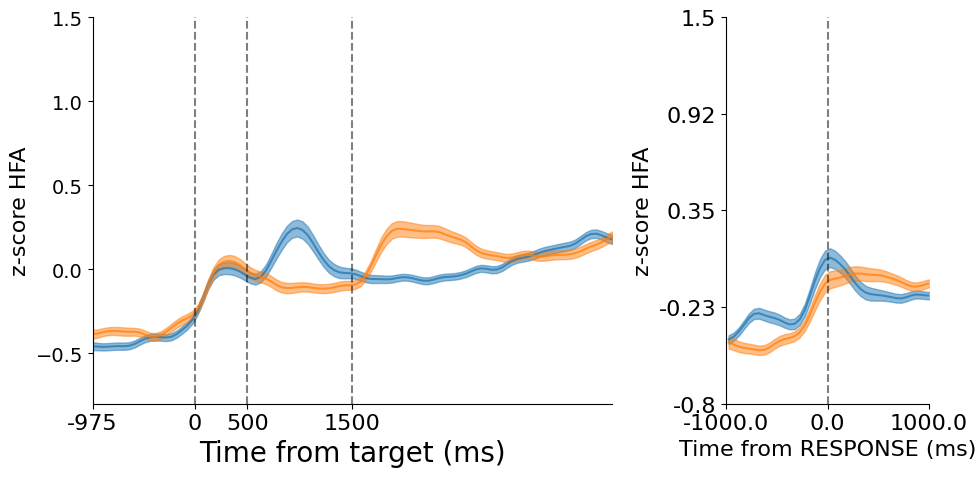

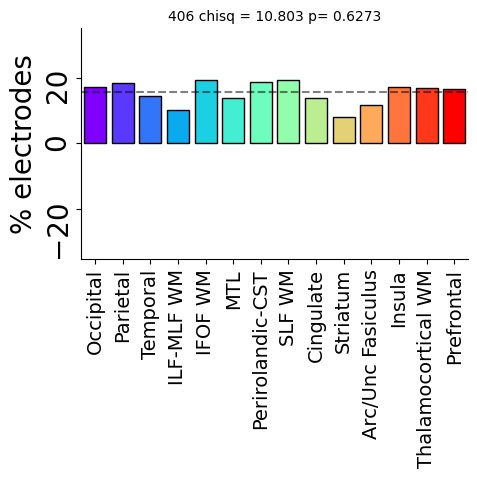

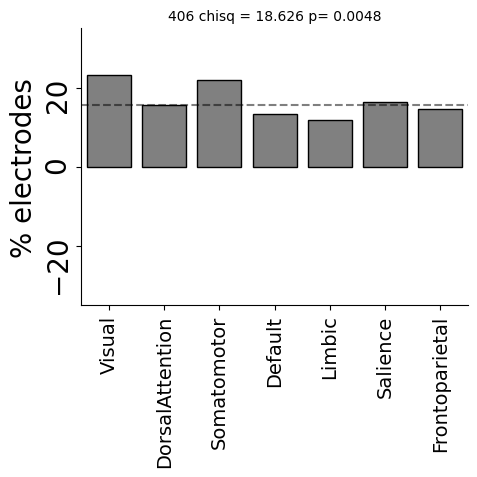

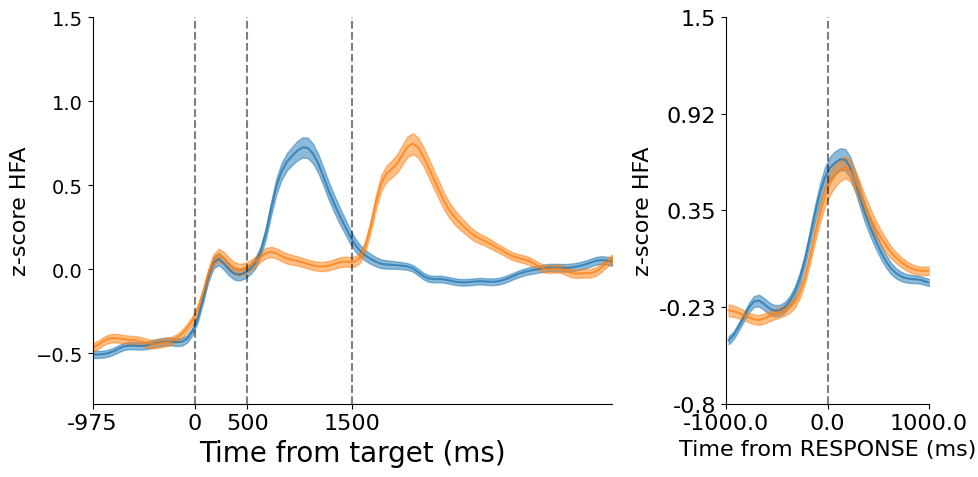

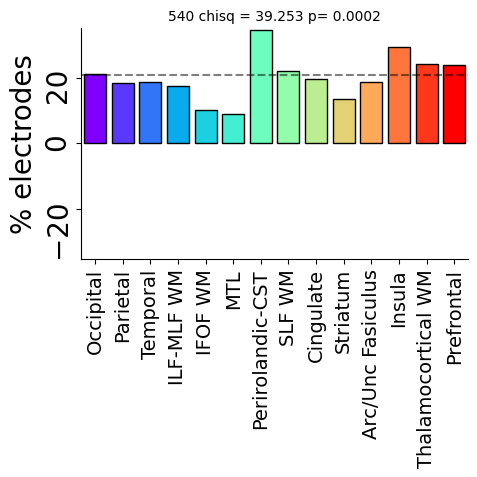

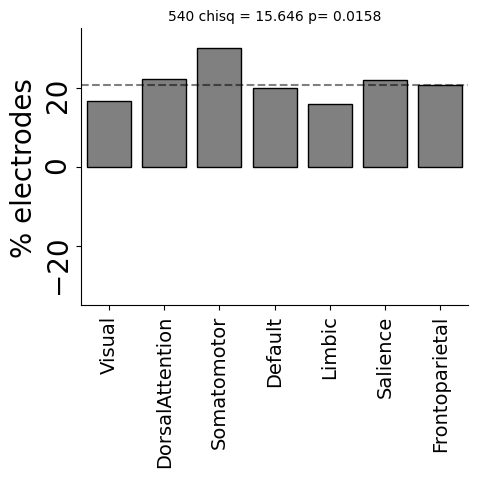

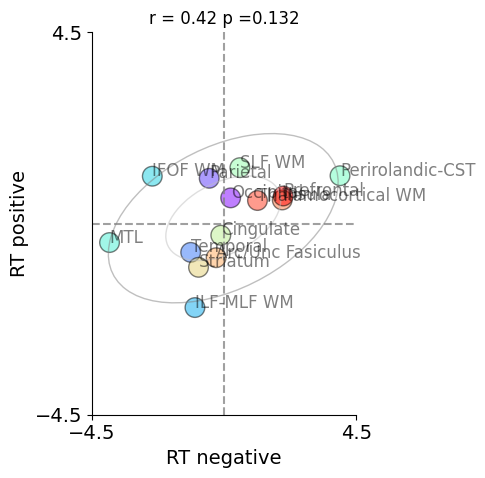

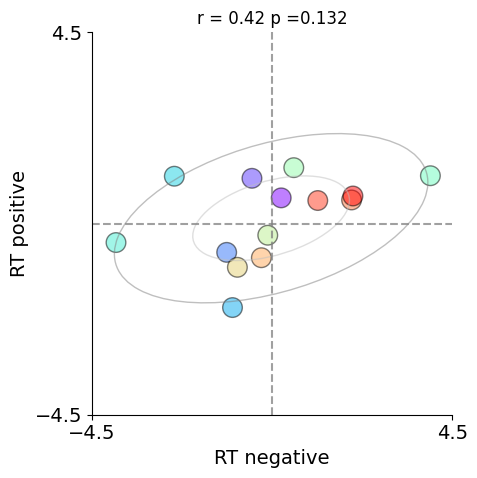

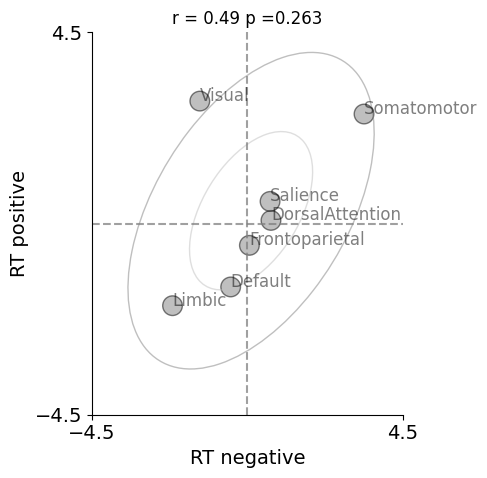

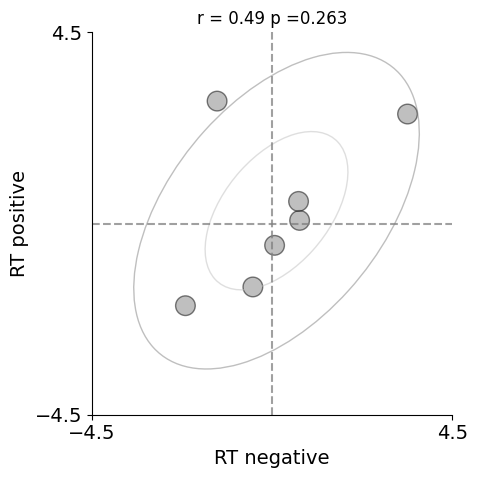

In [24]:
# Motivate clustering - showing heterogeneous RT selectivity activity within regions
# RT pos 
beh_feat = 'zrrtStoch'
p_thresh=0.05
n_feat_list = ['S0f','S0c','postCC','postCC_bur','preResponse_bur','preResponse']
#params
yL = (-0.8,1.5)

# any rt-related change
ret_idx_pos = np.zeros(len(C.taskstats2d_df)).astype('bool')
ret_idx_neg = np.zeros(len(C.taskstats2d_df)).astype('bool')

for n in n_feat_list:
    
    is_sig = (C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_pvalnp'].to_numpy()<p_thresh)
    is_pos = C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_rval'].to_numpy()>0
    is_neg = C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_rval'].to_numpy()<0
    ret_idx_pos =  ret_idx_pos|(is_sig&is_pos)
    ret_idx_neg =  ret_idx_neg|(is_sig&is_neg)
    
    
plot_dict_a,plot_dict_a_yeo = evalClus_wrapper2(ret_idx_pos,beh_feat=beh_feat,yL = yL,lbl='rtpos',binByRT = False,show_false_alarms = False,yL_anat=(-35,35))
plot_dict_b,plot_dict_b_yeo = evalClus_wrapper2(ret_idx_neg,beh_feat=beh_feat,yL = yL,lbl='rtneg',binByRT = False,show_false_alarms = False,yL_anat=(-35,35))

plot_anat_scatter(plot_dict_a,plot_dict_b,'rtpos_v_rtneg_2d_anatomy',lims=(-4.5,4.5),lbl_a='RT positive',lbl_b='RT negative')
plot_anat_scatter(plot_dict_a_yeo,plot_dict_b_yeo,'rtpos_v_rtneg_2d_anatomy-YEO',lims=(-4.5,4.5),lbl_a='RT positive',lbl_b='RT negative')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


total RT encoding
BinomTestResult(k=638, n=2609, alternative='greater', proportion_estimate=0.24453813721732465, pvalue=4.469549287302253e-246) 
 ConfidenceInterval(low=0.2307223214118668, high=1.0)



Occipital
BinomTestResult(k=28, n=81, alternative='greater', proportion_estimate=0.345679012345679, pvalue=1.208737735443299e-16) 
 ConfidenceInterval(low=0.25804509183365953, high=1.0)
pos
BinomTestResult(k=9, n=81, alternative='greater', proportion_estimate=0.1111111111111111, pvalue=0.01981251615485313) 
 ConfidenceInterval(low=0.05920257521726151, high=1.0)
neg
BinomTestResult(k=11, n=81, alternative='greater', proportion_estimate=0.13580246913580246, pvalue=0.0023208516903004805) 
 ConfidenceInterval(low=0.07806246273949168, high=1.0)
pos vs uniform
ConfidenceInterval(low=0.09784183851599945, high=0.2729587437223315) 0.6458964895231156
neg vs uniform
ConfidenceInterval(low=0.1272760687351285, high=0.3146274616564506) 0.8917084582200147



Parietal
BinomTestResult(k=34, n=135, altern

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_98688/1528158633.py:432: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_98688/1528158633.py:446: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




anyneg n elec =  323 n subj =  23


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_98688/1528158633.py:432: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_98688/1528158633.py:446: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1166: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1166: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya

ccpos_v_ccneg_2d_anatomy
chi-square test comparing frequencies across groups
chi2 50.254946743311685
dof 13
p 2.695654109260119e-06
ccpos_v_ccneg_2d_anatomy-YEO
chi-square test comparing frequencies across groups
chi2 21.607337748721527
dof 6
p 0.0014260548408281948


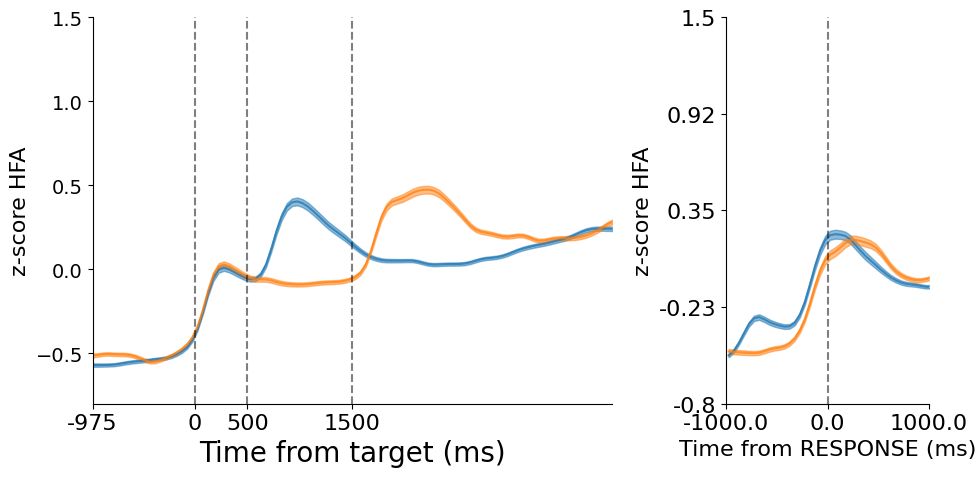

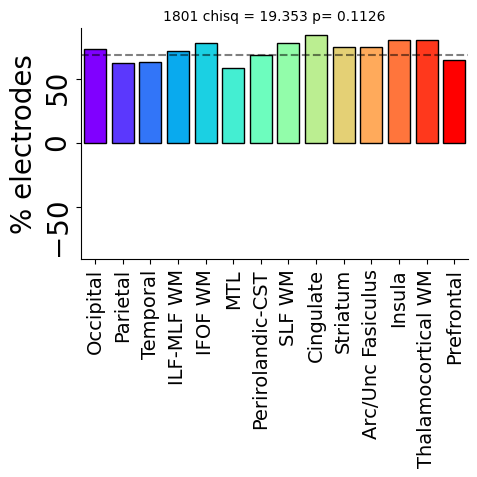

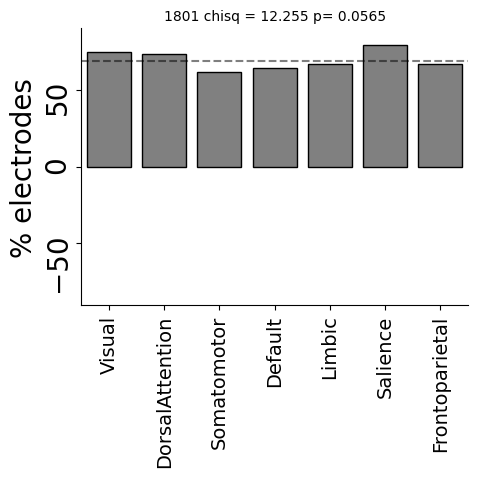

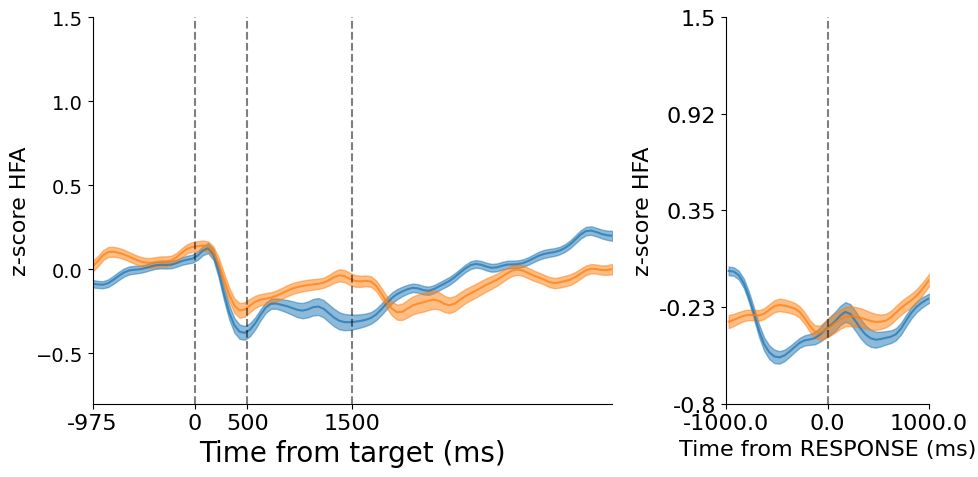

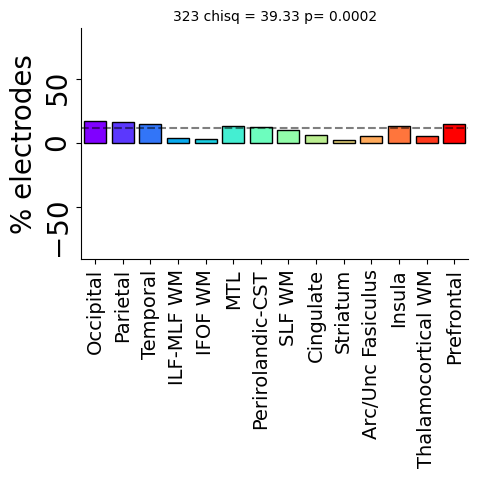

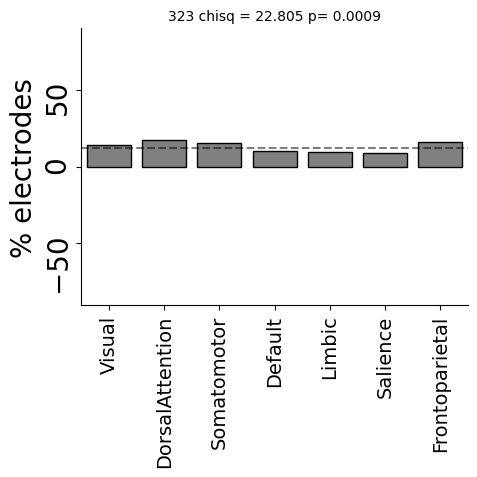

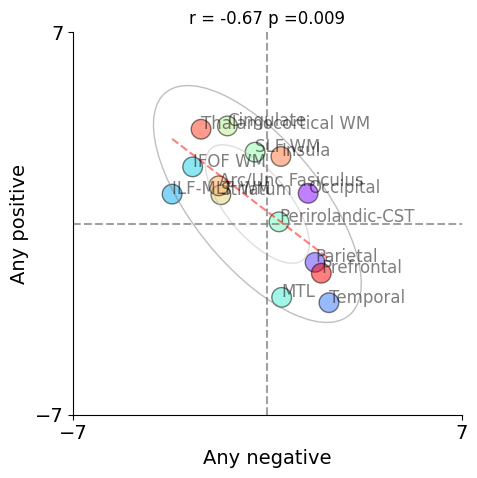

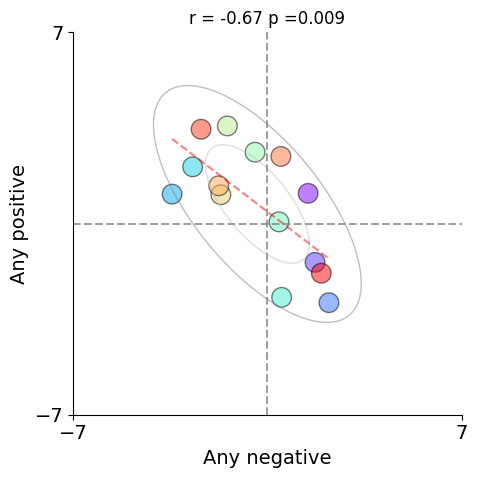

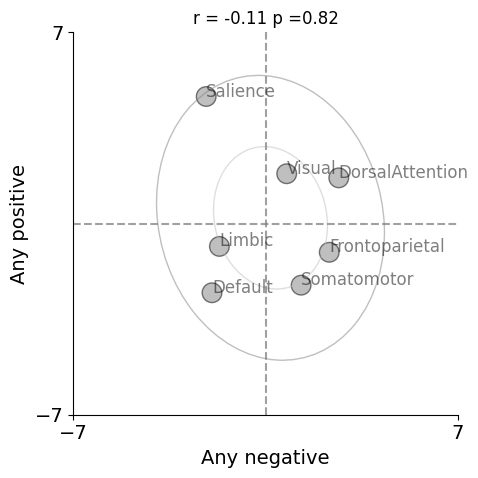

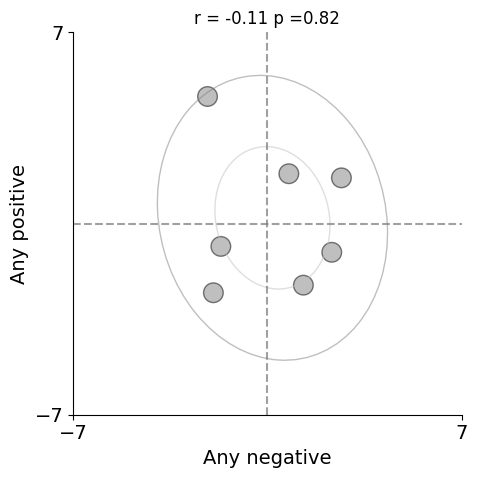

In [25]:
#STATS
# total RT encoding
tot = len(C.taskstats2d_df['rtRegress_multivar_zrrtStoch_SSE_pvalnp'])
isSig = np.sum(C.taskstats2d_df['rtRegress_multivar_zrrtStoch_SSE_pvalnp']<0.05)
isNSig = tot-isSig
expSig = .05*tot
expNSig = tot - expSig
res = stats.binomtest(isSig, tot, p = 0.05,alternative='greater')
print('total RT encoding')
print(res,'\n',res.proportion_ci())
print('\n\n')
#chisq,p = stats.chisquare(f_obs=(isSig,isNSig),f_exp=(expSig,expNSig)) # equal rates expected
#print(chisq,p)


# RT encoding by network
sigIdx = C.taskstats2d_df['rtRegress_multivar_zrrtStoch_SSE_pvalnp']<0.05
p_list = []
p_list_pos = []
p_list_neg = []
p_list_uni = []
lblList_uni = []

anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow',atlas='default');
for r in roiList:
    r_idx = anatDf['roi'].to_numpy()==r
    tot_r = np.sum(r_idx)
    isSig_r = np.sum(sigIdx&r_idx)
    isSig_r_pos = np.sum(sigIdx&r_idx&ret_idx_pos)
    isSig_r_neg = np.sum(sigIdx&r_idx&ret_idx_neg)
    #print(isSig_r/tot_r)
    
    res = stats.binomtest(isSig_r, tot_r, p = 0.05,alternative='greater')
    p_list.append(res.pvalue)
    
    print(r)
    print(res,'\n',res.proportion_ci())    
    
    res_pos = stats.binomtest(isSig_r_pos, tot_r, p = 0.05,alternative='greater')
    p_list_pos.append(res_pos.pvalue)
    
    print('pos')
    print(res_pos,'\n',res_pos.proportion_ci())


    res_neg = stats.binomtest(isSig_r_neg, tot_r, p = 0.05,alternative='greater')
    p_list_neg.append(res_neg.pvalue)
    
    print('neg')
    print(res_neg,'\n',res_neg.proportion_ci())
    
    
    print('pos vs uniform')
    print(plot_dict_a['binom_ci'][roiList.index(r)],plot_dict_a['binom_pvals'][roiList.index(r)])
    p_list_uni.append(plot_dict_a['binom_pvals'][roiList.index(r)])
    lblList_uni.append('pos-'+r)
    
    print('neg vs uniform')
    print(plot_dict_b['binom_ci'][roiList.index(r)],plot_dict_b['binom_pvals'][roiList.index(r)])
    print('\n\n')    
    p_list_uni.append(plot_dict_b['binom_pvals'][roiList.index(r)])
    lblList_uni.append('neg-'+r)
    
fdr_wrapper(p_list,roiList) 
fdr_wrapper(p_list_pos,roiList) 
fdr_wrapper(p_list_neg,roiList) 
fdr_wrapper(p_list_uni,lblList_uni) 
# How many sig elecs show both positive and negative encoding?
print('\n mixed n',np.sum(sigIdx&ret_idx_pos&ret_idx_neg))
print('\n mixed n',np.sum(sigIdx&ret_idx_pos&ret_idx_neg)/tot)
      
    


# Motivate clustering - showing heterogeneous task-related modulation  within regions
p_thresh =0.05
cc_idx_pos = (C.taskstats2d_df['postCC_tstat'].to_numpy()>0)&(C.taskstats2d_df['postCC_pval'].to_numpy()<=p_thresh)
cc_idx_neg = (C.taskstats2d_df['postCC_tstat'].to_numpy()<0)&(C.taskstats2d_df['postCC_pval'].to_numpy()<=p_thresh)
fix_idx_pos = (C.taskstats2d_df['postFix_tstat'].to_numpy()>0)&(C.taskstats2d_df['postFix_pval'].to_numpy()<=p_thresh)
fix_idx_neg = (C.taskstats2d_df['postFix_tstat'].to_numpy()<0)&(C.taskstats2d_df['postFix_pval'].to_numpy()<=p_thresh)
resp_idx_pos = (C.taskstats2d_df['postResponse_tstat'].to_numpy()>0)&(C.taskstats2d_df['postResponse_pval'].to_numpy()<=p_thresh)
resp_idx_neg = (C.taskstats2d_df['postResponse_tstat'].to_numpy()<0)&(C.taskstats2d_df['postResponse_pval'].to_numpy()<=p_thresh)


#ret_idx_pos = (C.taskstats2d_df['postCC_tstat'].to_numpy()>0)&(C.taskstats2d_df['postCC_pval'].to_numpy()<=p_thresh)
#ret_idx_neg = (C.taskstats2d_df['postCC_tstat'].to_numpy()<0)&(C.taskstats2d_df['postCC_pval'].to_numpy()<=p_thresh)

ret_idx_pos = (fix_idx_pos|cc_idx_pos|resp_idx_pos)
ret_idx_neg = (fix_idx_neg|cc_idx_neg|resp_idx_neg)
tot = len(ret_idx_neg)


plot_dict_a,plot_dict_a_yeo = evalClus_wrapper2(ret_idx_pos,beh_feat=beh_feat,yL = yL,lbl='anypos',binByRT = False,show_false_alarms = False,yL_anat=(-90,90))
plot_dict_b,plot_dict_b_yeo = evalClus_wrapper2(ret_idx_neg,beh_feat=beh_feat,yL = yL,lbl='anyneg',binByRT = False,show_false_alarms = False,yL_anat=(-90,90))

plot_anat_scatter(plot_dict_a,plot_dict_b,'ccpos_v_ccneg_2d_anatomy',lims=(-7,7),lbl_a='Any positive',lbl_b='Any negative')
plot_anat_scatter(plot_dict_a_yeo,plot_dict_b_yeo,'ccpos_v_ccneg_2d_anatomy-YEO',lims=(-7,7),lbl_a='Any positive',lbl_b='Any negative') 

In [17]:
# any task or rt mod
p_thresh=0.05
isRTMod = C.taskstats2d_df['rtRegress_multivar_zrrtStoch_SSE_pvalnp']<p_thresh
isTaskMod = (C.taskstats2d_df['postFix_pval'].to_numpy()<=p_thresh)|(C.taskstats2d_df['postCC_pval'].to_numpy()<=p_thresh)| (C.taskstats2d_df['postResponse_pval'].to_numpy()<=p_thresh)

np.sum(isRTMod|isTaskMod)

2142

In [18]:
#STATS

print('\nFreq of task increase:')
print(np.sum(ret_idx_pos),np.sum(ret_idx_pos)/len(ret_idx_pos))
print('\n')


print('\nFreq of task decrease:')
print(np.sum(ret_idx_neg),np.sum(ret_idx_neg)/len(ret_idx_neg))
print('\n')


print('\nMixed Responses are Rare:')
print(np.sum(ret_idx_pos&ret_idx_neg),np.sum(ret_idx_pos&ret_idx_neg)/len(ret_idx_pos))
print('\n')

print('We observed more task pos than task neg')
res_posNeg = stats.binomtest(np.sum(ret_idx_pos), (np.sum(ret_idx_pos)+np.sum(ret_idx_neg)), p = 0.5,alternative='two-sided')
print(res_posNeg,'\n',res_posNeg.proportion_ci())

p_list_pos = []
p_list_neg = []
p_list = [] 
lbl_list = [] 
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow',atlas='default');

for r in roiList:
    r_idx = anatDf['roi'].to_numpy()==r
    tot_r = np.sum(r_idx)
    isSig_r_pos = np.sum(cc_idx_pos&r_idx)
    isSig_r_neg = np.sum(cc_idx_neg&r_idx)
    
    
    print('\n\n')
    print(r,'pos cc vs chance')
    res_pos = stats.binomtest(isSig_r_pos, tot_r, p = 0.05,alternative='greater')
    p_list_pos.append(res_pos.pvalue)
    print(res_pos,'\n',res_pos.proportion_ci())
    
    print(r,'neg cc vs chance')
    res_neg = stats.binomtest(isSig_r_neg, tot_r, p = 0.05,alternative='greater')
    p_list_neg.append(res_neg.pvalue)
    print(res_neg,'\n',res_neg.proportion_ci())    
    
    
    print(r,'pos vs uniform')
    print(plot_dict_a['binom_ci'][roiList.index(r)],plot_dict_a['binom_pvals'][roiList.index(r)])
    p_list.append(plot_dict_a['binom_pvals'][roiList.index(r)])
    lbl_list.append('pos-'+r)
    
    print(r,'neg vs uniform')
    print(plot_dict_b['binom_ci'][roiList.index(r)],plot_dict_b['binom_pvals'][roiList.index(r)])
    print('\n\n')
    p_list.append(plot_dict_b['binom_pvals'][roiList.index(r)])
    lbl_list.append('neg-'+r)

    
fdr_wrapper(p_list_pos,roiList)
fdr_wrapper(p_list_neg,roiList)
fdr_wrapper(p_list,lbl_list)


Freq of task increase:
1801 0.6903027980068992



Freq of task decrease:
323 0.1238022230739747



Mixed Responses are Rare:
66 0.025297048677654272


We observed more task pos than task neg
BinomTestResult(k=1801, n=2124, alternative='two-sided', proportion_estimate=0.8479284369114878, pvalue=4.0236237777574426e-248) 
 ConfidenceInterval(low=0.8319430354179643, high=0.8629470451685097)



Occipital pos cc vs chance
BinomTestResult(k=41, n=81, alternative='greater', proportion_estimate=0.5061728395061729, pvalue=1.3065607318314006e-31) 
 ConfidenceInterval(low=0.4096524286744188, high=1.0)
Occipital neg cc vs chance
BinomTestResult(k=7, n=81, alternative='greater', proportion_estimate=0.08641975308641975, pvalue=0.11055975447657244) 
 ConfidenceInterval(low=0.04126347531958432, high=1.0)
Occipital pos vs uniform
ConfidenceInterval(low=0.6313970258516626, high=0.8318024633624743) 0.4001381661821437
Occipital neg vs uniform
ConfidenceInterval(low=0.09784183851599945, high=0.272958743722

array([0.50926676, 0.26126264, 0.22122681, 0.20149174, 0.02322499,
       0.08168532, 0.4966545 , 0.009564  , 0.14038516, 0.03942903,
       0.03011989, 0.79414297, 1.        , 0.83013199, 0.05419208,
       0.79414297, 0.009564  , 0.22122681, 0.58186113, 0.14975838,
       0.33780325, 0.14038516, 0.07270111, 0.79414297, 0.009564  ,
       0.06063335, 0.14038516, 0.14038516])

5


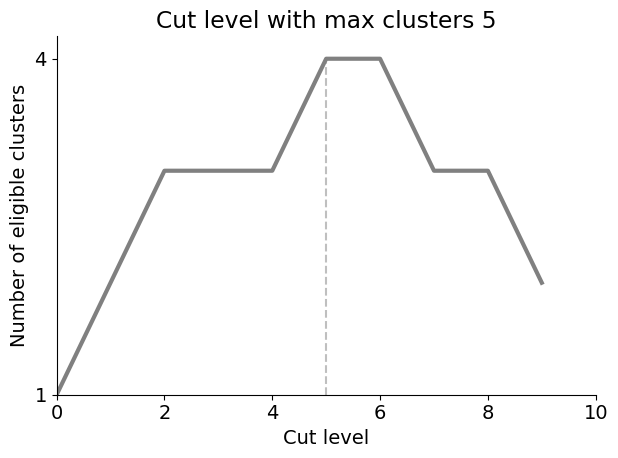

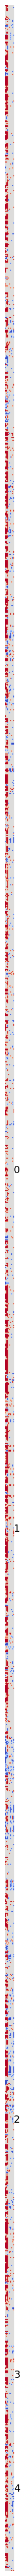

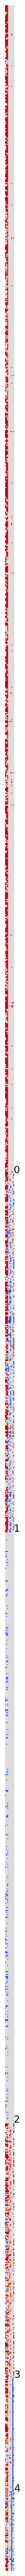

In [10]:
# show clustering results
f = plt.figure()   
ax = plt.subplot(111)
ax.plot(cut_levels_to_test,num_clus_by_level,linewidth=3,color ='0.5')
ax.set_ylabel('Number of eligible clusters')
ax.set_xlabel('Cut level')
ax.vlines(cut_levels_to_test[cut_level],ax.get_ylim()[0],\
          ax.get_ylim()[1],linestyle='--',color='0.5',alpha=0.5)
ax.set_title('Cut level with max clusters '+str(cut_levels_to_test[cut_level]))
ax.set_yticks([1,ax.get_ylim()[-1]])
ax.set_ylim(1,ax.get_ylim()[-1]+.2)
save_fig('optimal_clus_level')

cut_level = cut_levels_to_test[np.argmax(num_clus_by_level)]
print(cut_level) 
num_clus_by_level

# illustrate feature matrix (raw and clustered)
f = plt.figure(figsize=(5,50))
#ax = plt.subplot(111)
plt.imshow(C.clus_featMat_noz,cmap='coolwarm')
plt.gca().axis('off')
# include cluster labels here
sorted_idx = np.argsort(C.clus_cut_tree[:,cut_level])
sorted_lbls = C.clus_cut_tree[:,cut_level][sorted_idx]
transition_idx = np.where(np.diff(sorted_lbls)>0)[0]
for i in transition_idx:
    plt.gca().text(plt.gca().get_xlim()[-1],i,str(list(transition_idx).index(i)))
plt.tight_layout()
save_fig('feat_mat_unsorted')

featMat_sorted = C.clus_featMat_noz[np.argsort(C.clus_cut_tree[:,cut_level])]
f = plt.figure(figsize=(5,50))
#ax = plt.subplot(111)
plt.imshow(featMat_sorted,cmap='coolwarm')
plt.gca().axis('off')
# include cluster labels here
sorted_idx = np.argsort(C.clus_cut_tree[:,cut_level])
sorted_lbls = C.clus_cut_tree[:,cut_level][sorted_idx]
transition_idx = np.where(np.diff(sorted_lbls)>0)[0]
for i in transition_idx:
    plt.gca().text(plt.gca().get_xlim()[-1],i,str(list(transition_idx).index(i)))
plt.tight_layout()
save_fig('feat_mat_sorted_'+str(cut_level))

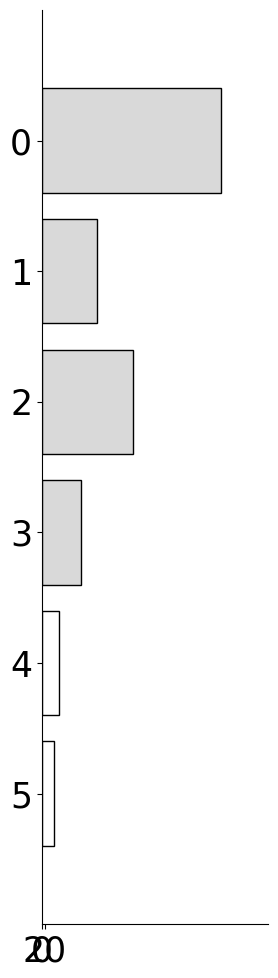

In [11]:
n_subj=[]
rt_idx = []
f=plt.figure(figsize=(3,10))
plt.gca().set_ylim(0,cut_level)
for i in np.arange(0,cut_level+1):
    clusid=i

    # ret_idx
    ret_idx = C.clus_cut_tree[:,cut_level]==clusid

    n_elecs=np.sum(ret_idx)
    # calc num subj
    n_subj=(np.count_nonzero(C.collapseBySubj_1d(ret_idx)))
    
    if (n_subj<20)|(n_elecs<200):
        col='w'
    elif (np.isin(i,rt_idx)==True):
        col='0.5'
        
    else:
        col='0.85'
    
    #bar
    plt.gca().barh(i,np.sum(ret_idx),color=col,edgecolor='k')#n_subj
    #plt.gca().text(1,i+.25,'('+str(n_elecs)+')',fontsize=20)
    
    

    


plt.gca().set_yticks(np.arange(0,cut_level+1))
plt.gca().set_yticklabels(plt.gca().get_yticklabels(),fontsize=25)
plt.gca().set_xticks([0,20])
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),fontsize=25)


plt.gca().set_ylim(-1,cut_level+1)
plt.gca().invert_yaxis()
plt.tight_layout()
save_fig('cluster_barplot')

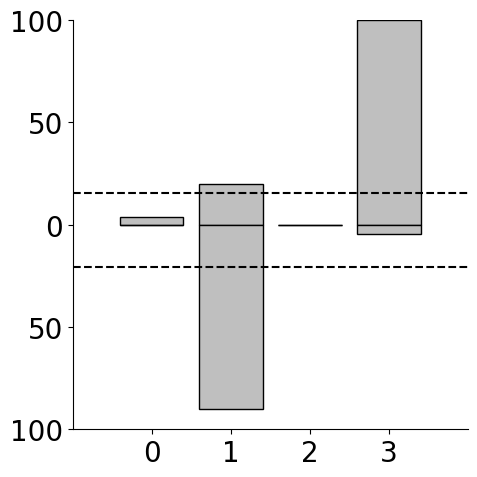

In [12]:
# Here we plot RT selectivity (any time window) for each cluster
min_subj=23
min_elec=200
# get RT selectivity
beh_feat = 'zrrtStoch'
p_thresh=0.05
n_feat_list = ['S0f','S0c','postCC','postCC_bur','preResponse_bur','preResponse']
#params
yL = (-0.8,1.5)

# any rt-related change
ret_idx_pos = np.zeros(len(C.taskstats2d_df)).astype('bool')
ret_idx_neg = np.zeros(len(C.taskstats2d_df)).astype('bool')

for n in n_feat_list:
    
    is_sig = (C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_pvalnp'].to_numpy()<p_thresh)
    is_pos = C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_rval'].to_numpy()>0
    is_neg = C.taskstats2d_df['rtCorr_'+beh_feat+'_'+n+'_clean_rval'].to_numpy()<0
    ret_idx_pos =  ret_idx_pos|(is_sig&is_pos)
    ret_idx_neg =  ret_idx_neg|(is_sig&is_neg)
    
n_subj=[]
rt_idx = []
f=plt.figure(figsize=(5,5))
for i in np.arange(0,cut_level+1):
    clusid=i
    # ret_idx
    ret_idx = C.clus_cut_tree[:,cut_level]==clusid
    
    n_elecs=np.sum(ret_idx)
    # calc num subj
    n_subj=(np.count_nonzero(C.collapseBySubj_1d(ret_idx)))
          
    if (n_subj<min_subj)|(n_elecs<min_elec):
        col='w'
        continue
    else:
        col='0.75'
    
    # plot percentage of any RT pos modulation 
    plt.gca().bar(i,100*np.sum(ret_idx_pos&ret_idx)/np.sum(ret_idx),color=col,edgecolor='k')                 
    # plot percentage of any RT pos modulation 
    plt.gca().bar(i,-100*np.sum(ret_idx_neg&ret_idx)/np.sum(ret_idx),color=col,edgecolor='k')

# hline
plt.gca().hlines(100*np.sum(ret_idx_pos)/len(ret_idx_pos),\
                 plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],linestyle='--',color='k')
plt.gca().hlines(-100*np.sum(ret_idx_neg)/len(ret_idx_neg),\
                 plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],linestyle='--',color='k')

plt.gca().set_yticks([-100,-50,0,50,100])
plt.gca().set_yticklabels(np.abs([-100,-50,0,50,100]),fontsize=20)
plt.gca().set_xticks([0,1,2,3])
plt.gca().set_xticklabels([0,1,2,3],fontsize=20)


plt.tight_layout()
save_fig('cluster_barplot-anyRT')

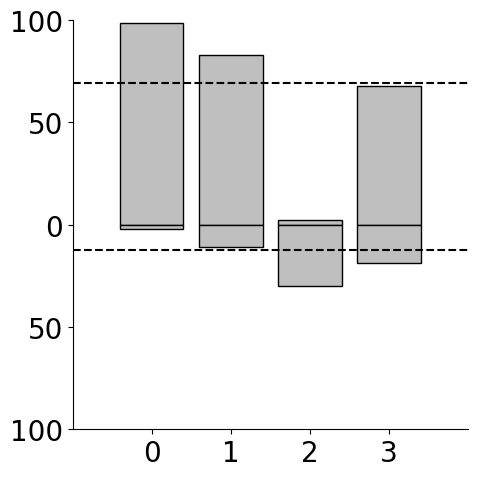

In [13]:
# Here we plot RT selectivity (any time window) for each cluster

# get RT selectivity
beh_feat = 'zrrtStoch'
p_thresh=0.05
n_feat_list = ['postFix','postCC','postResponse']
#params
yL = (-0.8,1.5)

# any rt-related change
ret_idx_pos = np.zeros(len(C.taskstats2d_df)).astype('bool')
ret_idx_neg = np.zeros(len(C.taskstats2d_df)).astype('bool')

for n in n_feat_list:
    
    is_sig = (C.taskstats2d_df[n+'_pval'].to_numpy()<p_thresh)
    is_pos = C.taskstats2d_df[n+'_tstat'].to_numpy()>0
    is_neg = C.taskstats2d_df[n+'_tstat'].to_numpy()<0
    ret_idx_pos =  ret_idx_pos|(is_sig&is_pos)
    ret_idx_neg =  ret_idx_neg|(is_sig&is_neg)
    
n_subj=[]
rt_idx = []
f=plt.figure(figsize=(5,5))
for i in np.arange(0,cut_level+1):
    clusid=i
    # ret_idx
    ret_idx = C.clus_cut_tree[:,cut_level]==clusid
    
    n_elecs=np.sum(ret_idx)
    # calc num subj
    n_subj=(np.count_nonzero(C.collapseBySubj_1d(ret_idx)))
          
    if (n_subj<min_subj)|(n_elecs<min_elec):
        col='w'
        continue
    else:
        col='0.75'
    
    # plot percentage of any RT pos modulation 
    plt.gca().bar(i,100*np.sum(ret_idx_pos&ret_idx)/np.sum(ret_idx),color=col,edgecolor='k')                 
    # plot percentage of any RT pos modulation 
    plt.gca().bar(i,-100*np.sum(ret_idx_neg&ret_idx)/np.sum(ret_idx),color=col,edgecolor='k')
    
    
plt.gca().hlines(100*np.sum(ret_idx_pos)/len(ret_idx_pos),\
    plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],linestyle='--',color='k')
plt.gca().hlines(-100*np.sum(ret_idx_neg)/len(ret_idx_neg),\
                 plt.gca().get_xlim()[0],plt.gca().get_xlim()[1],linestyle='--',color='k')
plt.gca().set_yticks([-100,-50,0,50,100])
plt.gca().set_yticklabels(np.abs([-100,-50,0,50,100]),fontsize=20)
plt.gca().set_xticks([0,1,2,3])
plt.gca().set_xticklabels([0,1,2,3],fontsize=20)

plt.tight_layout()
save_fig('cluster_barplot-anyTaskModulation')

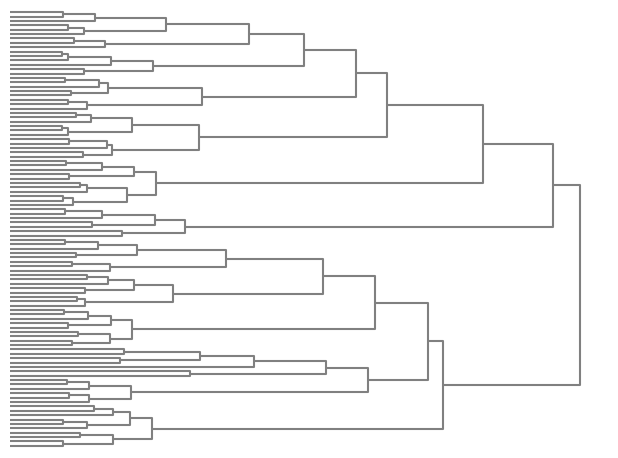

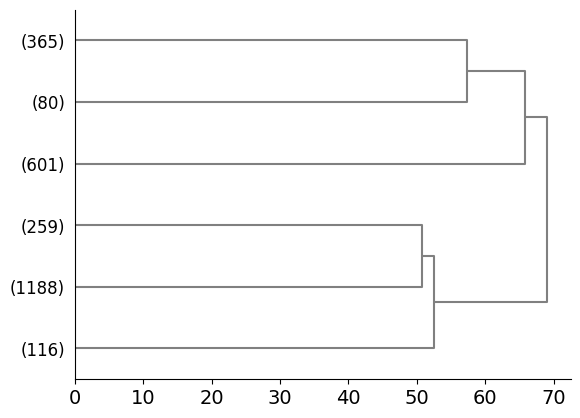

In [14]:
#C.clus_plotDendrogram(cut_level=(cut_level+1).astype('int'),figsize=(7,7))

from scipy import cluster
cluster.hierarchy.dendrogram(Z=C.clus_Z,\
                             above_threshold_color='0.5',\
                             p =100,truncate_mode='lastp',\
                             show_leaf_counts =True, \
                             ax = None,\
                             color_threshold =0,\
                             orientation='right',count_sort=None);
plt.gca().axis('off')
save_fig('dendrogram')

f,ax =plt.subplots()
cluster.hierarchy.dendrogram(Z=C.clus_Z,\
                             above_threshold_color='0.5',\
                             p =int(cut_level)+1,truncate_mode='lastp',\
                             show_leaf_counts =True, \
                             ax = None,\
                             color_threshold =0,\
                             orientation='right',count_sort=None);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13705: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




clus id 0 n elec =  1188 n subj =  23


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_94224/285231316.py:45: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:10154: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.abs(ax.get_yticks()).astype('int'))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13705: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
No artists 



clus id 1 n elec =  365 n subj =  23


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_94224/285231316.py:45: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:10154: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.abs(ax.get_yticks()).astype('int'))




clus id 2 n elec =  601 n subj =  23


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13705: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_94224/285231316.py:45: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func



clus id 3 n elec =  259 n subj =  23


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_94224/285231316.py:45: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:10154: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.abs(ax.get_yticks()).astype('int'))




clus id 4 n elec =  116 n subj =  22


clus id 5 n elec =  80 n subj =  21
FDR-corrected p values
[['5-0' '0.01']
 ['5-1' '0.001']
 ['5-2' '0.01']
 ['5-3' '0.015']]


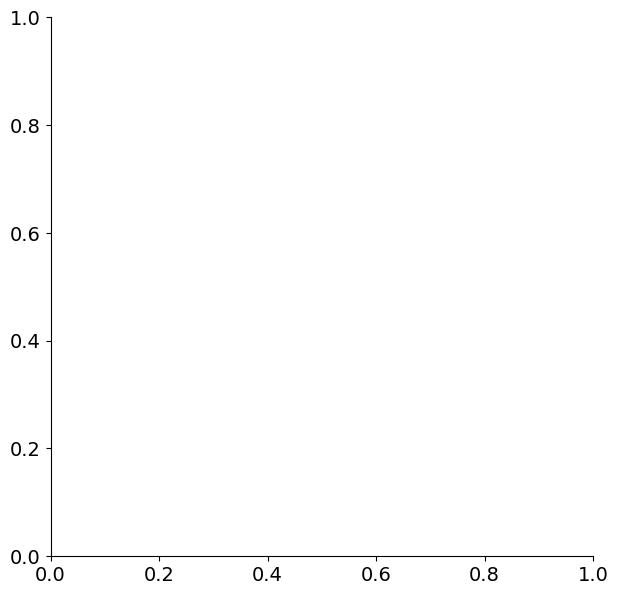

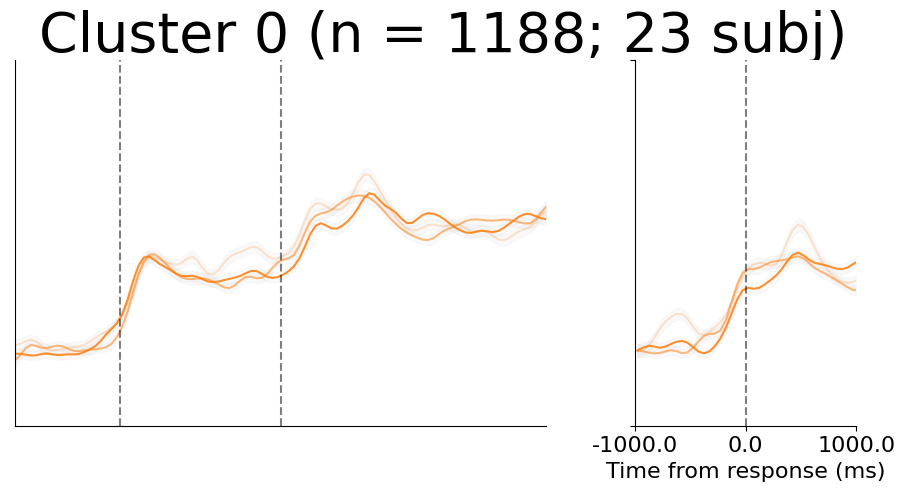

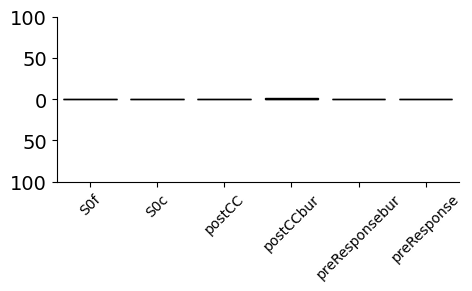

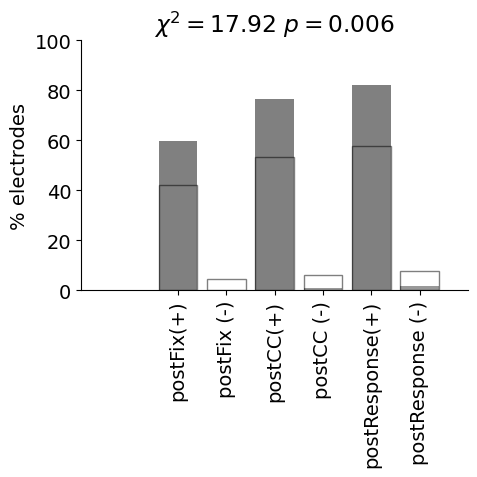

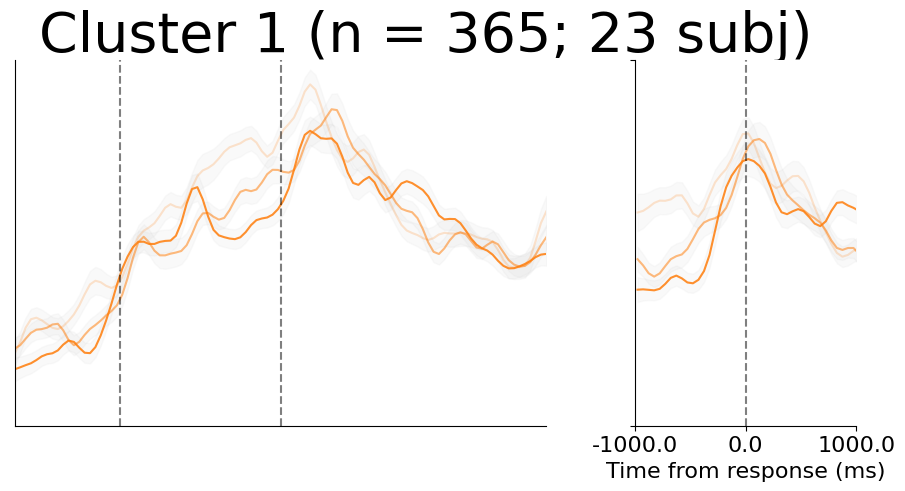

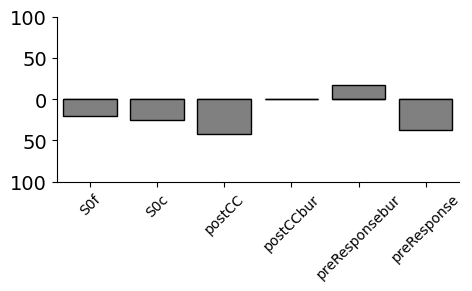

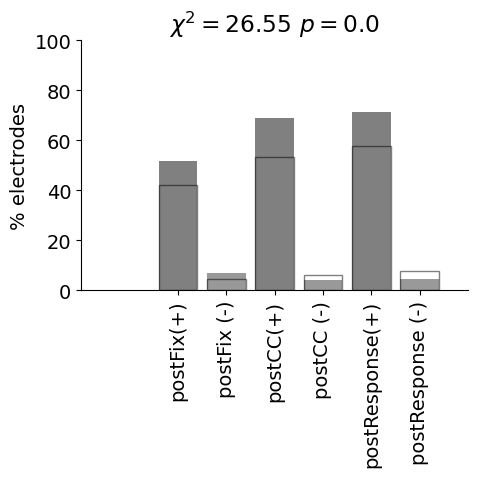

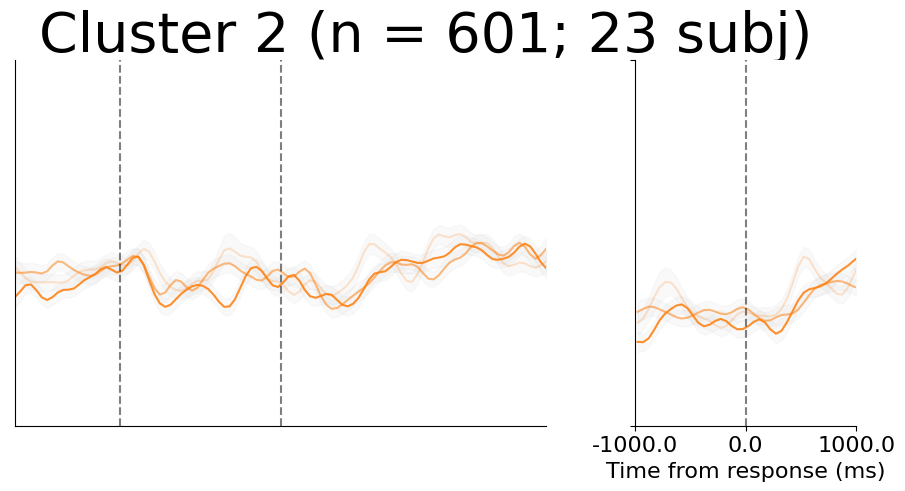

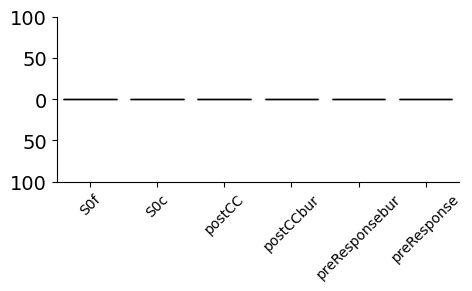

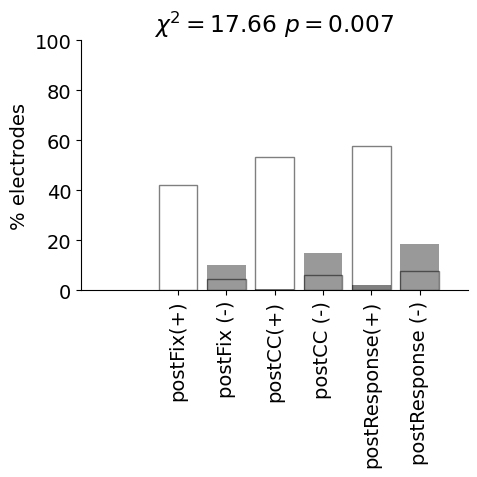

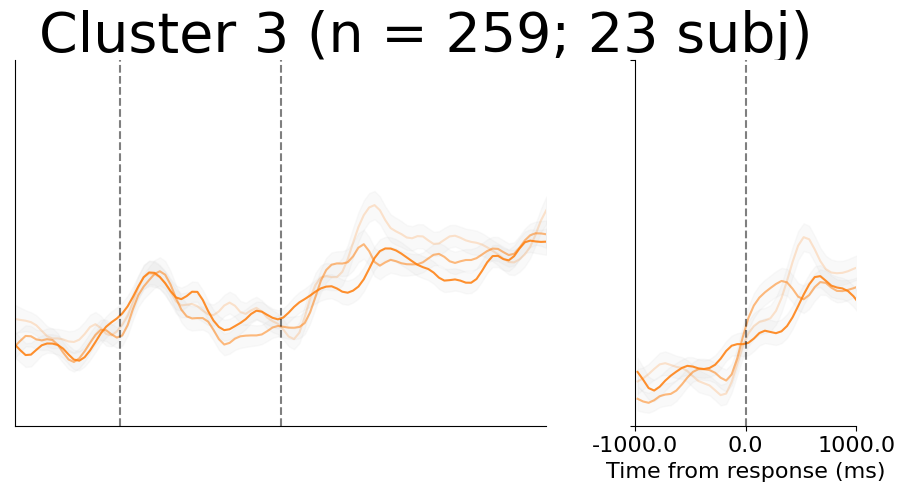

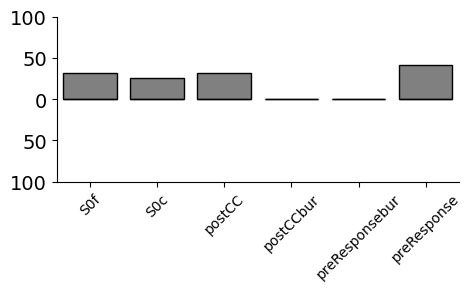

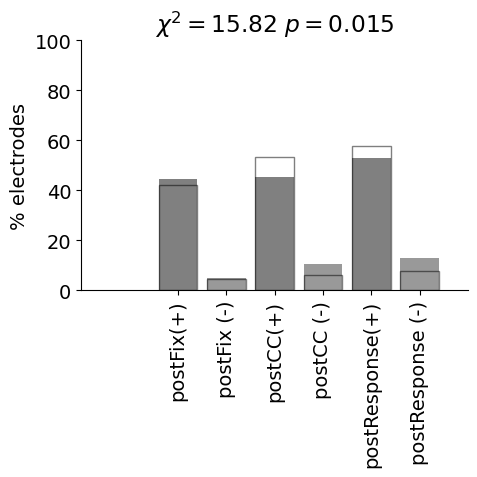

In [21]:
### Clustering based on task-related responses
#NOTE: Cut level = 11 actually gives you 12 clusters
min_subj = 23
min_elec = 200
p_list,lbl_list,stats_df = explore_level(cut_level=cut_level,beh_feat = 'zrrtStoch',\
                                         yL = (-1,1.2),atlas='yeo',\
                                         min_subj = min_subj, min_elec=min_elec,\
                                         binByRT=True,delays_list=[1500],show_false_alarms=False)
#p_list,lbl_list,stats_df = explore_level(cut_level=cut_level,beh_feat = beh_feat,yL = (-0.75,1.2),atlas='default',min_subj = min_subj, min_elec=min_elec,binByRT=False,delays_list=[500,1500])


pvals_corrected = fdr_wrapper(p_list,lbl_list)

# update df with corrected p-values
stats_df.insert(len(stats_df.columns),'p_corr',np.round(pvals_corrected,2))
#save table
stats_df.to_csv(fig_dir+'cluster_table.csv')    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_38439/763422129.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_fix.set_yticklabels(np.round(ax_fix.get_yticks(),2),fontsize=20)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_38439/763422129.py:165: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_fix.set_yticklabels(np.round(ax_fix.get_yticks(),2),fontsize=20)
No artists with labels found to put in legend.  Note that artists whose l

Visual -3.309389141862613
DorsalAttention -0.12775582462109608
Somatomotor 2.928150477145051
Default -0.49124093299942995
Limbic -2.686771787920637
Salience 1.5737382274727674
Frontoparietal 1.6035071014343336


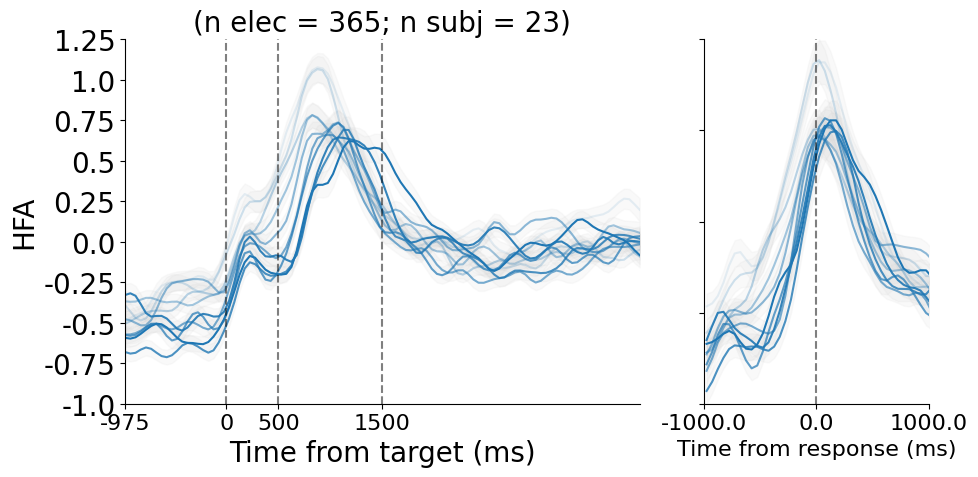

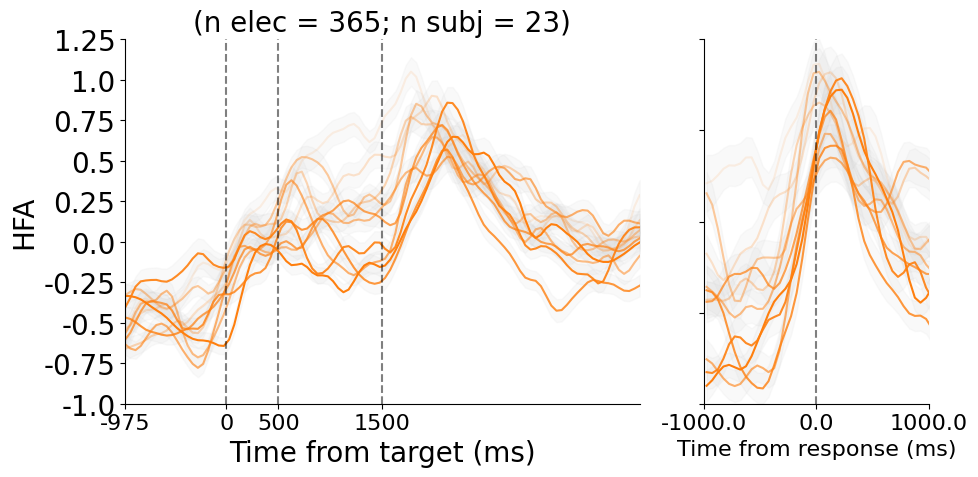

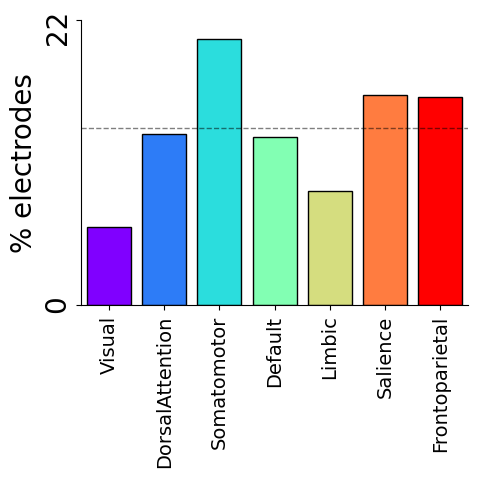

In [18]:
# activation functions for key clusters    
# first, cluster 1
ret_idx = C.clus_cut_tree[:,cut_level]==1
ret_str = 'Cluster1'

plotAct(ret_idx,yL = None,beh_feat = 'zrrtStoch',atlas='yeo',min_subj = 5, min_elec=50,binByRT=True,delays_list=[500])
save_fig(ret_str+'-actFunc-short')
plotAct(ret_idx,yL = None,beh_feat = 'zrrtStoch',atlas='yeo',min_subj = 5, min_elec=50,binByRT=True,delays_list=[1500])
save_fig(ret_str+'-actFunc-long')
plotAnat(ret_idx)
save_fig(ret_str+'-anat-'+atlas)



cluster-0 n elec =  1188 n subj =  23


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13527: RuntimeWarning: Mean of empty slice
  binPowMat = np.nanmean(getattr(self,'binPow_'+str(d)),axis=0).T
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13535: RuntimeWarning: Mean of empty slice
  binPowMat_mean = np.nanmean(binPowMat,axis=0)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13538: RuntimeWarning: Mean of empty slice
  ax.plot(self.pow_xval,np.nanmean(binPowMat,axis=0), color = color,alpha = this_alpha)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_32174/158698643.py:431: UserWarning: FixedFormatter should only b



cluster-1 n elec =  365 n subj =  23


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_32174/158698643.py:431: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_32174/158698643.py:445: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13527: RuntimeWarning: Mean of empty slice
  binPowMat = np.nanmean(getattr(self,'binPow_'+str(d)),axis=0).T
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13535: RuntimeWarning: Mean of empty slice
  binPowMat_mean = np.nanmean(binPowMat,axis=0)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13538: RuntimeWarning: Mean of empty slice
  ax.plot(self.pow_xval,np.nanmean(binPowMat,axi



cluster-2 n elec =  601 n subj =  23


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_32174/158698643.py:431: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_32174/158698643.py:445: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13527: RuntimeWarning: Mean of empty slice
  binPowMat = np.nanmean(getattr(self,'binPow_'+str(d)),axis=0).T
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13535: RuntimeWarning: Mean of empty slice
  binPowMat_mean = np.nanmean(binPowMat,axis=0)
/Users/ashw



cluster-3 n elec =  259 n subj =  23


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_32174/158698643.py:431: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_32174/158698643.py:445: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)


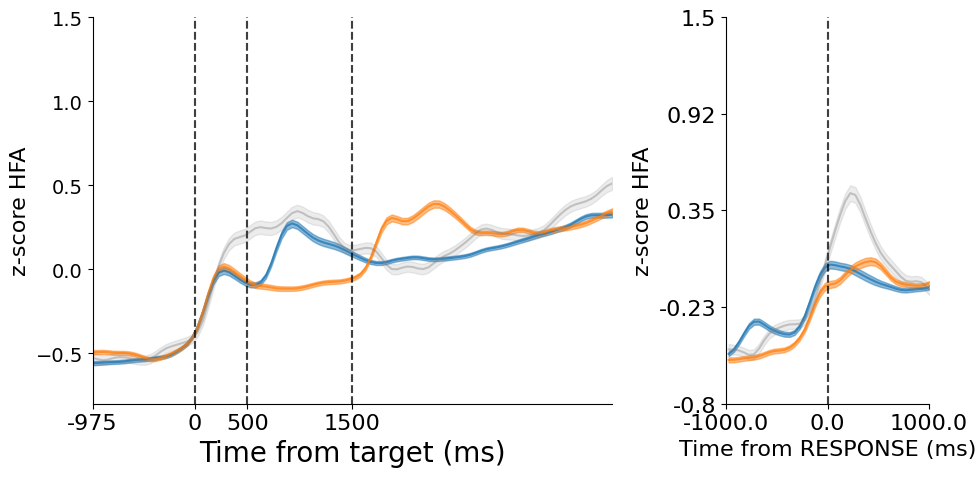

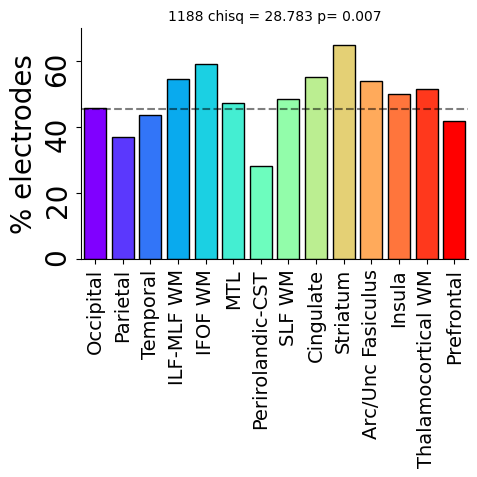

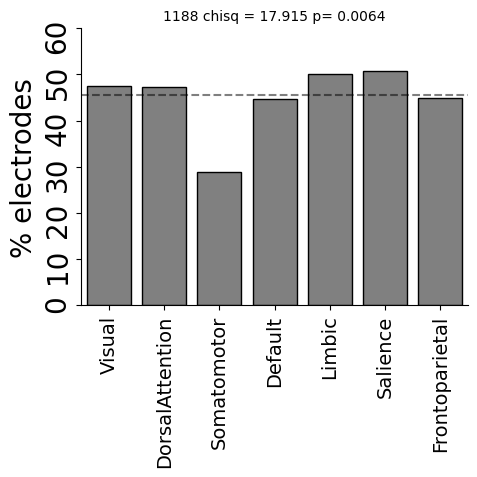

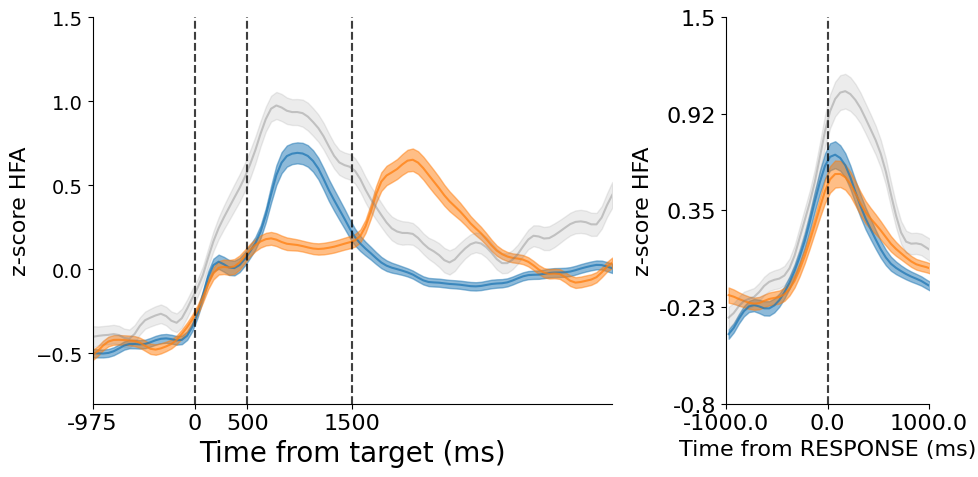

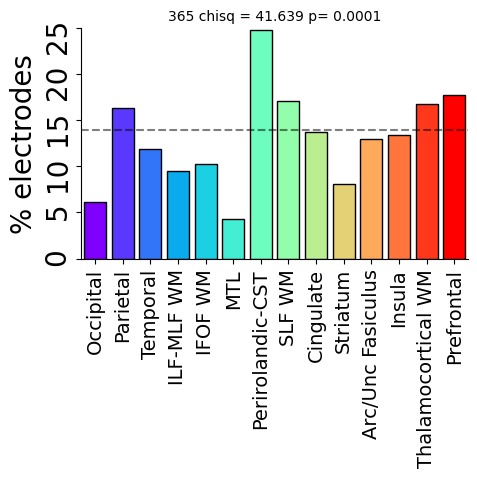

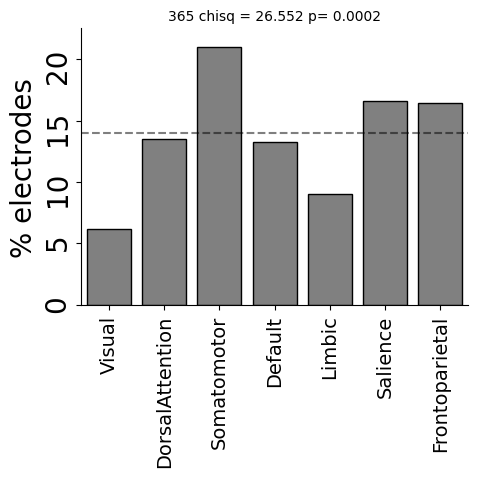

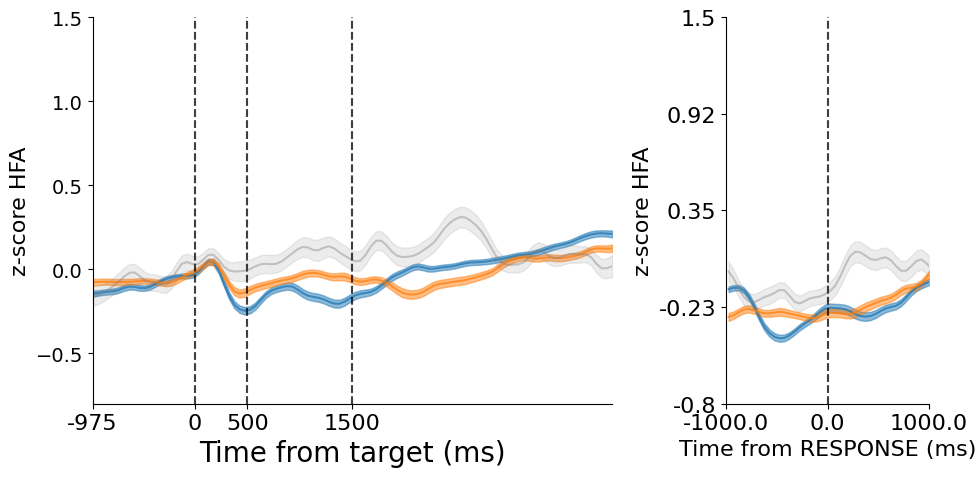

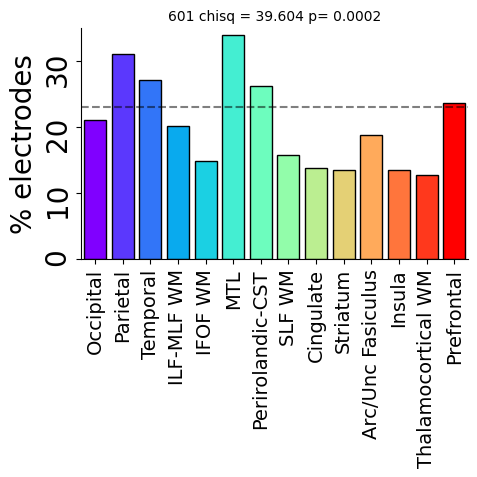

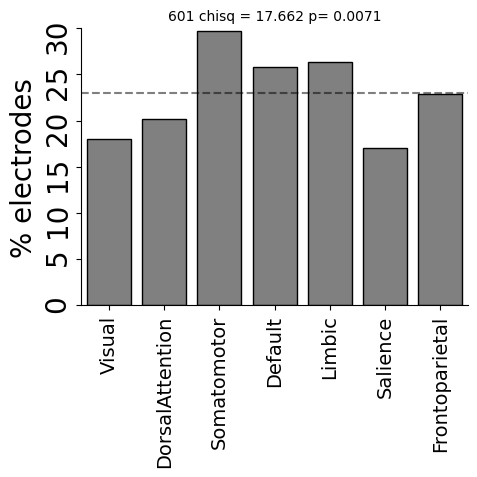

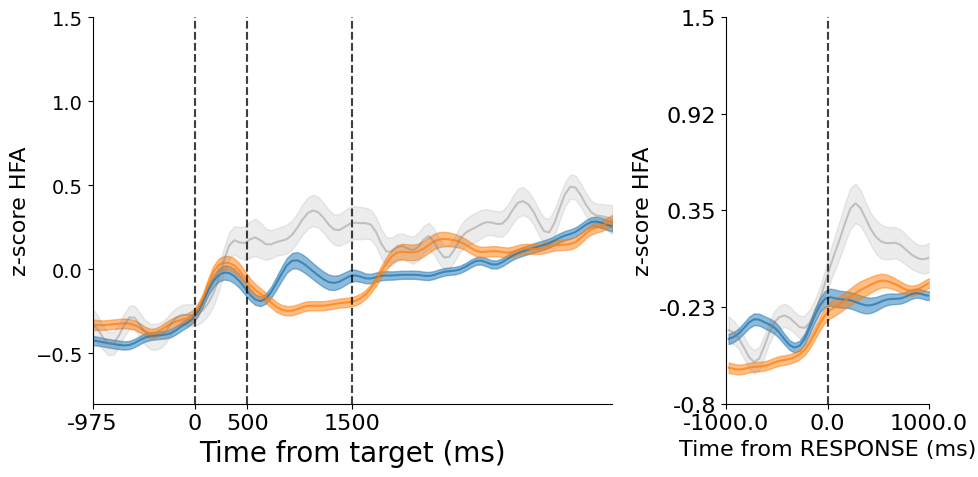

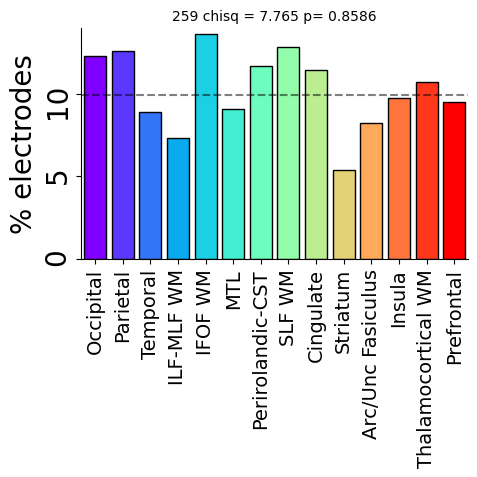

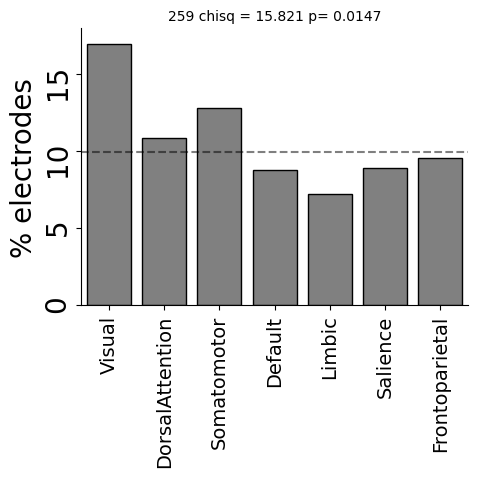

In [10]:
# plot full activation functions for all clusters
min_subj=23
min_elec=200
for i in np.arange(0,cut_level+1):
    clusid=i
    # ret_idx
    ret_idx = C.clus_cut_tree[:,cut_level]==clusid
    
    n_elecs=np.sum(ret_idx)
    # calc num subj
    n_subj=(np.count_nonzero(C.collapseBySubj_1d(ret_idx)))
          
    if (n_subj<min_subj)|(n_elecs<min_elec):
        col='w'
        continue
    else:
        plot_dict_a,plot_dict_a_yeo = evalClus_wrapper2(ret_idx,beh_feat=beh_feat,yL = yL,lbl='cluster-'+str(i),binByRT = False,show_false_alarms = True,yL_anat=None)


/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13527: RuntimeWarning: Mean of empty slice
  binPowMat = np.nanmean(getattr(self,'binPow_'+str(d)),axis=0).T
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13535: RuntimeWarning: Mean of empty slice
  binPowMat_mean = np.nanmean(binPowMat,axis=0)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13538: RuntimeWarning: Mean of empty slice
  ax.plot(self.pow_xval,np.nanmean(binPowMat,axis=0), color = color,alpha = this_alpha)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.




cluster1 n elec =  365 n subj =  23


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_33497/158698643.py:431: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_33497/158698643.py:445: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13527: RuntimeWarning: Mean of empty slice
  binPowMat = np.nanmean(getattr(self,'binPow_'+str(d)),axis=0).T
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13535: RuntimeWarning: Mean of empty slice
  binPowMat_mean = np.nanmean(binPowMat,axis=0)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:13538: RuntimeWarning: Mean of empty slice
  ax.plot(self.pow_xval,np.nanmean(binPowMat,axi



cluster3 n elec =  259 n subj =  23


/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_33497/158698643.py:431: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/var/folders/b8/qywy2vc912n5d7kkr2x3mf000000gn/T/ipykernel_33497/158698643.py:445: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(plt.gca().get_yticklabels(),rotation=90,fontsize=20)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/ccdt/ccdt_func.py:1111: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,c=color,edgecolor =edgecolor,alpha = alpha,s = s,cmap=cmap)
/Users/ashwinramayya/D

clus1_v_clus3_2d_anatomy
chi-square test comparing frequencies across groups
chi2 17.893037655586518
dof 13
p 0.1616231553950189
clus1_v_clus3_2d_anatomy-YEO
chi-square test comparing frequencies across groups
chi2 22.938159202610798
dof 6
p 0.0008174574534305971


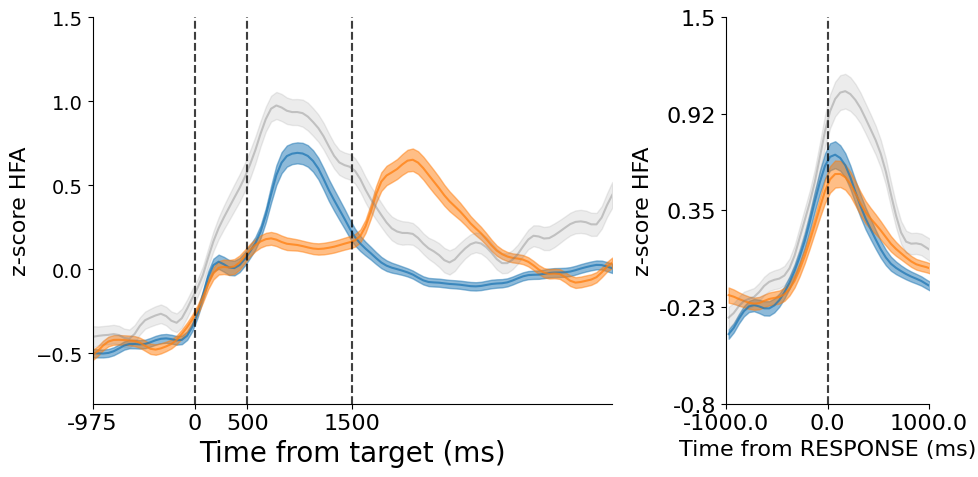

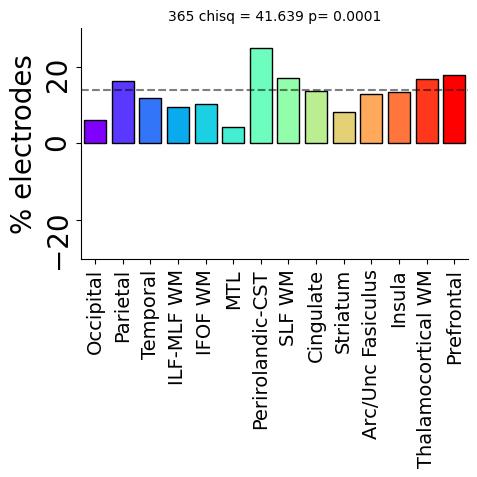

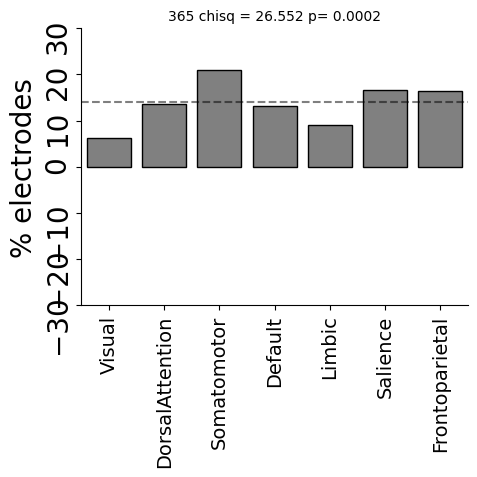

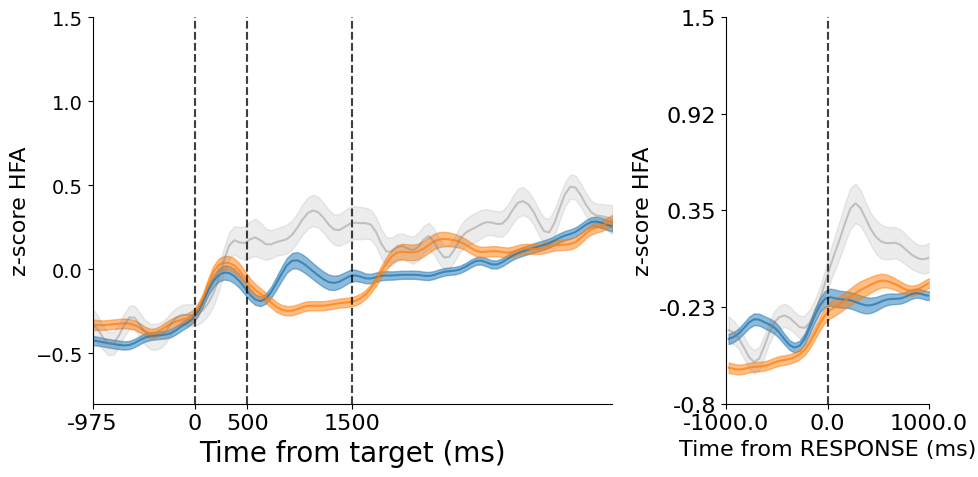

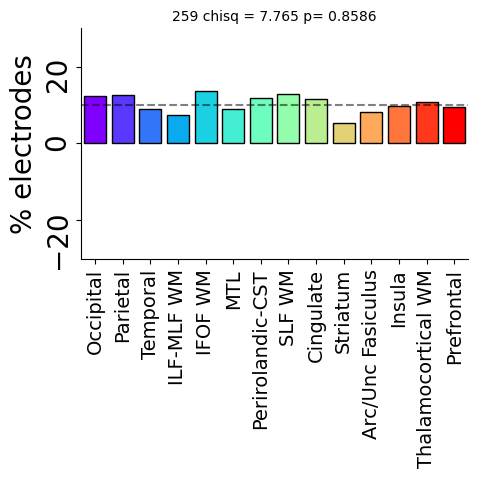

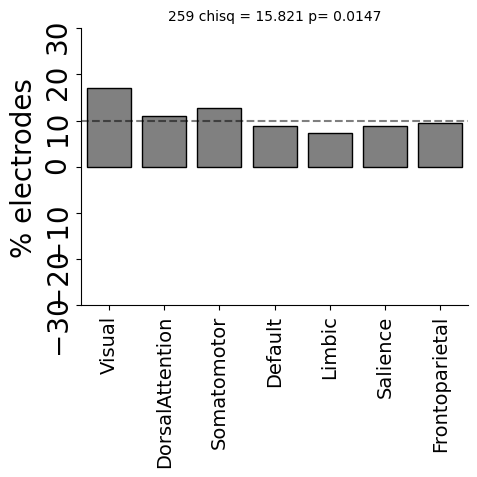

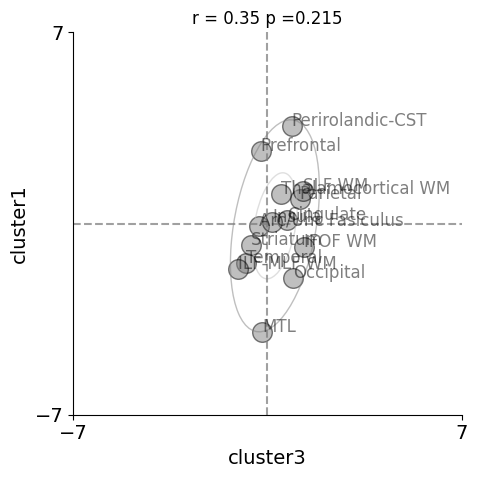

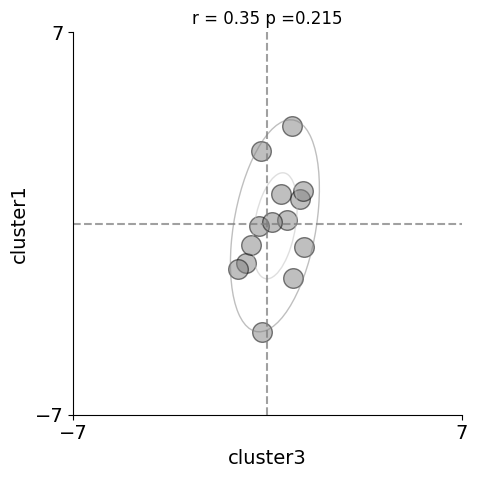

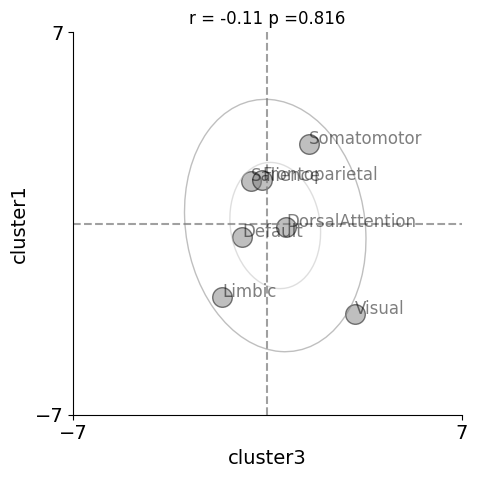

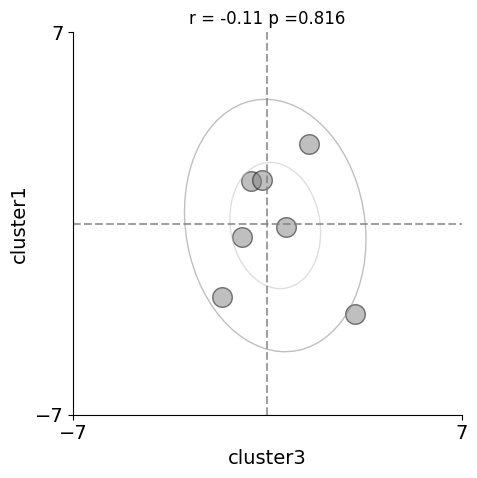

In [31]:
# compare cluster 1 and 3 anatomy
ret_idx_a = C.clus_cut_tree[:,cut_level]==1
ret_idx_b = C.clus_cut_tree[:,cut_level]==3


plot_dict_a,plot_dict_a_yeo = evalClus_wrapper2(ret_idx_a,beh_feat=beh_feat,yL = yL,lbl='cluster1',binByRT = False,show_false_alarms = True,yL_anat=(-30,30))
plot_dict_b,plot_dict_b_yeo = evalClus_wrapper2(ret_idx_b,beh_feat=beh_feat,yL = yL,lbl='cluster3',binByRT = False,show_false_alarms = True,yL_anat=(-30,30))

plot_anat_scatter(plot_dict_a,plot_dict_b,'clus1_v_clus3_2d_anatomy',lims=(-7,7),lbl_a='cluster1',lbl_b='cluster3')
plot_anat_scatter(plot_dict_a_yeo,plot_dict_b_yeo,'clus1_v_clus3_2d_anatomy-YEO',lims=(-7,7),lbl_a='cluster1',lbl_b='cluster3')

In [17]:
# ad hoc brain plot
# plot cluster 1 & somatomotor (FA + RT correlation) - MAGENTA
# plot cluster 1 & visual, salience and frontoparietal (RT correlation) - GREEN
# plot cluster 1 & default (FA correlation) - RED
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow',atlas='yeo');


clus_idx = C.clus_cut_tree[:,cut_level]==1
ret_idx_a = (C.clus_cut_tree[:,cut_level]==1)#&(anatDf.eval("roi=='Somatomotor'")|anatDf.eval("roi=='DorsalAttention'"))
ret_idx_b = (C.clus_cut_tree[:,cut_level]==3)#&(anatDf.eval("roi=='Visual'"))#clus_idx&(anatDf.eval("roi=='Somatomotor'")|anatDf.eval("roi=='DorsalAttention'"))
ret_idx_c = np.zeros(len(clus_idx)).astype('bool')#clus_idx==False

c_array = anatDf['roi_color'].to_numpy()
def update_col(c_array,ret_idx_a,ret_idx_b,col1=(0,1,0,1),col2=(1,0,0,1),col3=(1,0,1,1)):
    
    for i in range(0,len(c_array)):
        if ret_idx_a[i]==True:
            c_array[i] = np.array(col1)
        elif ret_idx_b[i] == True:
            c_array[i] = np.array(col2)
        elif ret_idx_c[i] == True:
            c_array[i] = np.array(col3)
            
            
    return c_array
    
        
c_array = update_col(c_array,ret_idx_a,ret_idx_b,col1=(1,0,0,1),col2=(0,1,0,1),col3=(.5,.5,.5,0.2))      
ret_idx = (ret_idx_a|ret_idx_b|ret_idx_c)
C.evalClus_brainPlot(ret_idx,c=c_array,marker_size=10,plot_on_single_surface=False,save_fullpath=fig_dir+'brainPlot-clusListA-v-clusListB')
C.evalClus_brainPlot(ret_idx,c=c_array,marker_size=10,plot_on_single_surface=True,save_fullpath=fig_dir+'brainPlot-clusListA-v-clusListB')

In [25]:
# DO Cluster 1 vs. Cluster 3 STATS

#STATS

# Clus vs. Clus 3 by network
p_list = []
p_list_a = []
p_list_b = []
p_list_uni = []
lblList_uni = []

print('expected clus 1\n',np.sum(ret_idx_a)/len(ret_idx_a))
print('expected clus 3\n',np.sum(ret_idx_b)/len(ret_idx_b))
anatDf,roiList = C.getAnatDf(ret_idx=None,cmap='rainbow',atlas='yeo');
for r in roiList:
    print(r)
    r_idx = anatDf['roi'].to_numpy()==r
    tot_r = np.sum(r_idx)
    isSig_r_pos = np.sum(r_idx&ret_idx_a)
    isSig_r_neg = np.sum(r_idx&ret_idx_b)
    #print(isSig_r/tot_r)
    
    
    print('clus 1 vs uniform')
    print(plot_dict_a_yeo['binom_ci'][roiList.index(r)],plot_dict_a_yeo['binom_pvals'][roiList.index(r)])
    
    p_list_a.append(plot_dict_a_yeo['binom_pvals'][roiList.index(r)])    
    p_list_uni.append(plot_dict_a_yeo['binom_pvals'][roiList.index(r)])
    lblList_uni.append('clus1-'+r)
    
    print('clus3 vs uniform')
    print(plot_dict_b_yeo['binom_ci'][roiList.index(r)],plot_dict_b_yeo['binom_pvals'][roiList.index(r)])
    print('\n\n')    
    p_list_b.append(plot_dict_b_yeo['binom_pvals'][roiList.index(r)])
    p_list_uni.append(plot_dict_b_yeo['binom_pvals'][roiList.index(r)])
    lblList_uni.append('clus3-'+r)
    
#fdr_wrapper(p_list,roiList) 
fdr_wrapper(p_list_a,roiList) 
fdr_wrapper(p_list_b,roiList) 
fdr_wrapper(p_list_uni,lblList_uni) 

    


expected clus 1
 0.1399003449597547
expected clus 3
 0.09927175162897663
Visual
clus 1 vs uniform
ConfidenceInterval(low=0.03236705095384734, high=0.10555600074878398) 0.0008536844820764512
clus3 vs uniform
ConfidenceInterval(low=0.12007811885018385, high=0.23050980442829924) 0.0023928118892857153



DorsalAttention
clus 1 vs uniform
ConfidenceInterval(low=0.09888348186507402, high=0.1790607163488434) 0.8687322055493987
clus3 vs uniform
ConfidenceInterval(low=0.07616473362605367, high=0.14954267121686865) 0.5639855408109713



Somatomotor
clus 1 vs uniform
ConfidenceInterval(low=0.1580752180621397, high=0.2700455165603419) 0.004509031512633734
clus3 vs uniform
ConfidenceInterval(low=0.08666656232441693, high=0.17945896431157793) 0.17351785792833646



Default
clus 1 vs uniform
ConfidenceInterval(low=0.10720877172858594, high=0.16079957863462438) 0.6110548847212203
clus3 vs uniform
ConfidenceInterval(low=0.06709279533251086, high=0.11212366022191589) 0.35830946700697286



Limbic
clus 1

array([0.01195158, 0.01674968, 0.86873221, 0.71289737, 0.02104215,
       0.30365625, 0.71289737, 0.55737028, 0.02501031, 0.27453058,
       0.27453058, 0.71289737, 0.27453058, 0.86873221])